# Prueba: Ópalo Quant Capital

## 5 Machine Learning

In [1]:
###################################################################################################
# Project    : Prueba Opalo Quant Capital
# Lenguaje   : Python / jupyter
# Description: Seccion de Machine Learning
#
# References : 
# Git Control:
# Author - Year:Camilo Blanco Vargas - 2020
# Mail         :mail@camiloblanco.com 
###################################################################################################

# usando el excel "prueba_opalo.xlsx" hoja "variables_mercados" y usando un modelo de aprendizaje supervisado 
# hacer el pronostico de la variable "colombia", ojo tener en cuenta las otras variables

In [2]:
# 1. Import the necesary libraries and Read dataset from excel file
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import keras.backend as kb
import tensorflow as tf
from datetime import datetime

#Using Nvidia GPU card
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
# Read datset from excel file
data_file='variables_mercados.xlsx'
df_full = pd.read_excel(data_file)
# Display the head of the dataset
df_full.head()

,date,next_colombia,next_change,day,colombia,usa,europa,asia,global,emergentes
0,2019-12-31,1662.0,0,0,1662.0,3217.0,41.67,73.21,53.74,44.72
1,2020-01-01,1659.0,-1,1,1662.0,3217.0,41.67,73.21,53.74,44.72
2,2020-01-02,1676.0,1,2,1659.0,3256.0,42.44,74.91,54.68,45.78
3,2020-01-03,1676.0,0,3,1676.0,3236.0,41.84,73.72,54.20,44.93
4,2020-01-04,1676.0,0,4,1676.0,3236.0,41.84,73.72,54.20,44.93


In [4]:
# 2. Describe and visualize the data set
train_stats = df_full.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
next_colombia,349.0,1258.186246,198.193544,894.000,1142.00,1178.00,1271.00,1676.00
next_change,349.0,0.022923,0.794768,-1.000,-1.00,0.00,1.00,1.00
day,349.0,174.000000,100.891856,0.000,87.00,174.00,261.00,348.00
colombia,349.0,1258.876791,199.179839,894.000,1142.00,1178.00,1271.00,1676.00
usa,349.0,3197.665989,306.775935,2305.000,3009.00,3270.00,3382.00,3711.31
europa,349.0,37.595616,4.237285,26.010,35.98,38.63,40.90,44.39
asia,349.0,72.792335,7.947828,54.010,68.09,73.94,77.62,88.11
global,349.0,53.943983,4.846620,39.630,50.95,54.96,57.12,62.34
emergentes,349.0,37.190799,15.641609,1.066,39.53,43.52,45.20,51.18


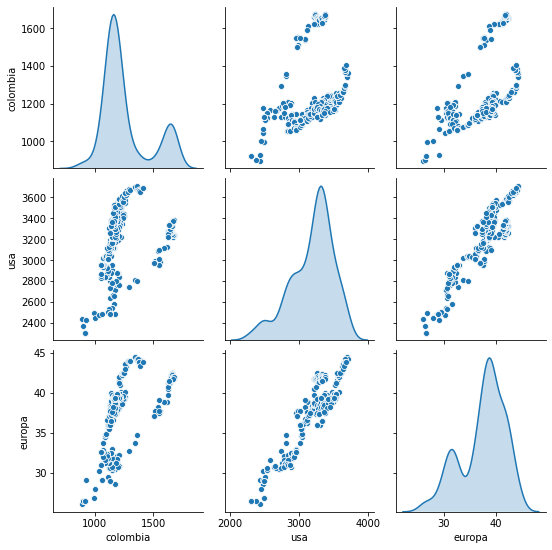

In [5]:
sns.pairplot(df_full [["colombia","usa", "europa"]], diag_kind="kde")

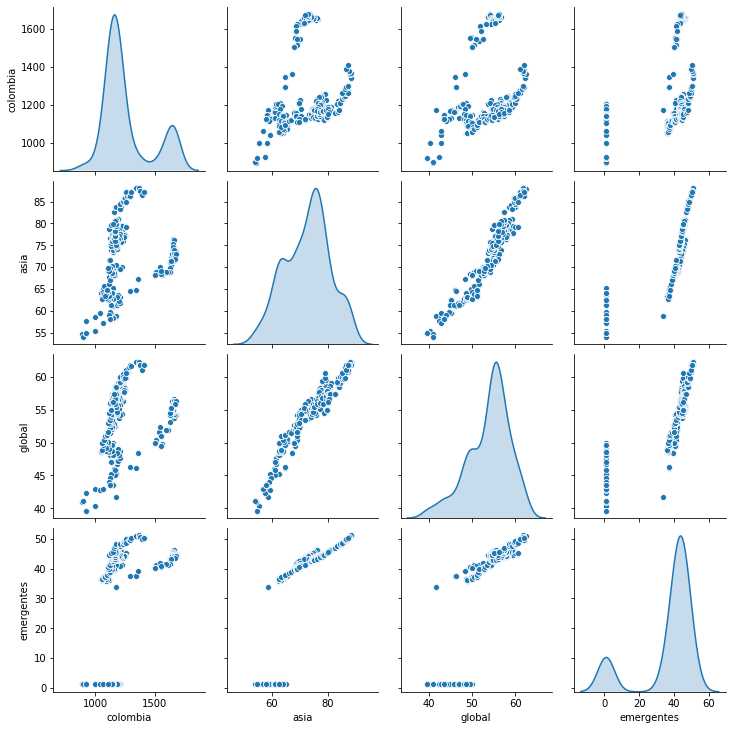

In [6]:
sns.pairplot(df_full [["colombia","asia","global", "emergentes"]], diag_kind="kde")

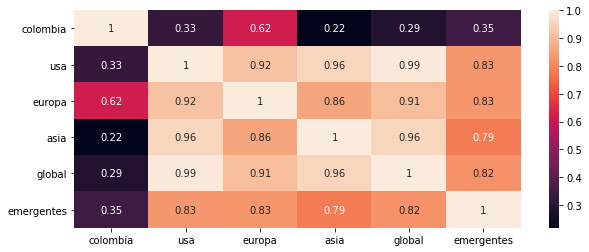

In [7]:
fig=plt.figure(figsize=(10,4))
sns.heatmap(df_full[["colombia","usa", "europa","asia","global", "emergentes"]].corr(), annot=True)
plt.show()

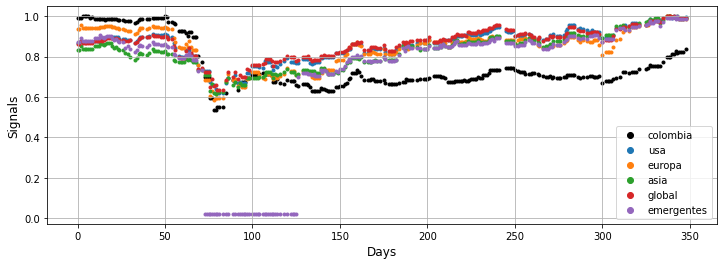

In [8]:
# 3. Drop undesidered Columns, Split the dataset, Extract, Scale and Visualize

# Drop undesidered Columns
# To use all features keep the next lines commented
#df_full = df_full.drop(columns=['colombia','emergentes'])
#config_key = "independant"

#Trivial Configuration
#df_full = df_full.drop(columns=['emergentes'])
#config_key = "Trivial"

#Split the dataset
train_df = df_full.sample(frac=0.8,random_state=0)
test_df = df_full.drop(train_df.index)

# Extract to numpy arrays
train_data=train_df.to_numpy()
test_data=test_df.to_numpy()
train_data_shape= train_data.shape
test_data_shape= test_data.shape

# Select day (time)
train_time= train_data[:,3]
test_time= test_data[:,3]

# Select target values or labels
Y_max=train_data[:,1].max()
y_train = train_data [:,4]/Y_max
y_test = test_data[:,4]/Y_max

# Select Feautures
X_max=train_data[:,5:10].max(axis=0)
x_train= train_data[:,5:10]/X_max
x_test =test_data[:,5:10]/X_max

# Visualize target value and most correlated Feautures vs time
fig=plt.figure(figsize=(12,4))
plt.ylabel('Signals', fontsize=12)
plt.xlabel('Days', fontsize=12)
# Visualize colombia vs time
plt.scatter(train_time,y_train,marker=".", color="black")
# usa
plt.scatter(train_time,x_train[:,0],marker=".")
# europa
plt.scatter(train_time,x_train[:,1],marker=".")
# asia
plt.scatter(train_time,x_train[:,2],marker=".")
# global
plt.scatter(train_time,x_train[:,3],marker=".")
# emergentes
plt.scatter(train_time,x_train[:,4],marker=".")

plt.legend(["colombia","usa", "europa","asia","global", "emergentes"],loc="lower right",markerscale=2)

plt.grid()
plt.show()

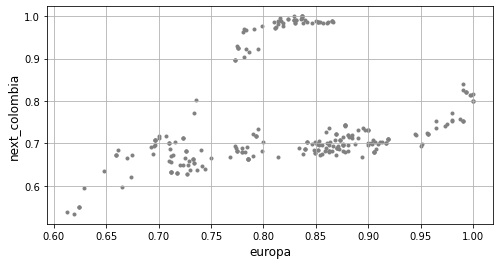

In [9]:
# Visualize next_colombia vs colombia
fig=plt.figure(figsize=(8,4))
plt.ylabel('next_colombia', fontsize=12)
plt.xlabel('europa', fontsize=12)
plt.scatter(x_train[:,2],y_train,marker=".", color="gray")
plt.grid()
plt.show()

In [10]:
# 4. Create and compile a neural network using Keras Sequiential method
# The architectue (number of layers, activations, etc) was esstablished after many trials

model = keras.Sequential([
    
    # First layer: 
    keras.layers.Dense(12, activation='relu', input_shape=(x_train.shape[1],)),
    # Middle layers
    keras.layers.Dense(6, activation='relu'),
    # Last layer: 
    keras.layers.Dense(1, activation='relu'),
])

# Compile the model, using RMSprop optimizer
model.compile(optimizer='RMSprop', loss='mse', metrics=['mse','mae'])

# Print the model characteristics
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                72        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Train the neural network, and visualize errors,
# Define the epochs number for the run
EPOCHS=5000
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=EPOCHS, verbose=1)

Train on 279 samples, validate on 70 samples
Epoch 1/5000
279/279 [==============================] - 0s 1ms/step - loss: 0.4828 - mse: 0.4828 - mae: 0.6758 - val_loss: 0.3610 - val_mse: 0.3610 - val_mae: 0.5819
Epoch 2/5000
279/279 [==============================] - 0s 82us/step - loss: 0.3247 - mse: 0.3247 - mae: 0.5465 - val_loss: 0.2432 - val_mse: 0.2432 - val_mae: 0.4719
Epoch 3/5000
279/279 [==============================] - 0s 82us/step - loss: 0.2206 - mse: 0.2206 - mae: 0.4445 - val_loss: 0.1609 - val_mse: 0.1609 - val_mae: 0.3770
Epoch 4/5000
279/279 [==============================] - 0s 79us/step - loss: 0.1453 - mse: 0.1453 - mae: 0.3525 - val_loss: 0.0996 - val_mse: 0.0996 - val_mae: 0.2868
Epoch 5/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0897 - mse: 0.0897 - mae: 0.2638 - val_loss: 0.0572 - val_mse: 0.0572 - val_mae: 0.2043
Epoch 6/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0522 - mse: 0.0522 - mae: 0.1858 - val_los

279/279 [==============================] - 0s 90us/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0885 - val_loss: 0.0102 - val_mse: 0.0102 - val_mae: 0.0742
Epoch 50/5000
279/279 [==============================] - 0s 90us/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0865 - val_loss: 0.0102 - val_mse: 0.0102 - val_mae: 0.0798
Epoch 51/5000
279/279 [==============================] - 0s 93us/step - loss: 0.0116 - mse: 0.0116 - mae: 0.0867 - val_loss: 0.0104 - val_mse: 0.0104 - val_mae: 0.0873
Epoch 52/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0895 - val_loss: 0.0101 - val_mse: 0.0101 - val_mae: 0.0788
Epoch 53/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0843 - val_loss: 0.0117 - val_mse: 0.0117 - val_mae: 0.0983
Epoch 54/5000
279/279 [==============================] - 0s 90us/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0907 - val_loss: 0.0102 - val_mse: 0.0102 - val_mae: 0.0836
Epoch 

Epoch 98/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0841 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0749
Epoch 99/5000
279/279 [==============================] - 0s 90us/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0779 - val_loss: 0.0114 - val_mse: 0.0114 - val_mae: 0.0987
Epoch 100/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0871 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0786
Epoch 101/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0839 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0750
Epoch 102/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0819 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0845
Epoch 103/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0839 - val_loss: 0.0093 - val_mse: 0.0093 - val_

279/279 [==============================] - 0s 82us/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0781 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0707
Epoch 147/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0763 - val_loss: 0.0091 - val_mse: 0.0091 - val_mae: 0.0848
Epoch 148/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0817 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0683
Epoch 149/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0770 - val_loss: 0.0081 - val_mse: 0.0081 - val_mae: 0.0714
Epoch 150/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0762 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0819
Epoch 151/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0777 - val_loss: 0.0081 - val_mse: 0.0081 - val_mae: 0.0736
E

279/279 [==============================] - 0s 83us/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0699 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0725
Epoch 195/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0707 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0693
Epoch 196/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0688 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0720
Epoch 197/5000
279/279 [==============================] - 0s 83us/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0698 - val_loss: 0.0068 - val_mse: 0.0068 - val_mae: 0.0678
Epoch 198/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0693 - val_loss: 0.0068 - val_mse: 0.0068 - val_mae: 0.0690
Epoch 199/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0702 - val_loss: 0.0068 - val_mse: 0.0068 - val_mae: 0.0684
E

279/279 [==============================] - 0s 82us/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0607 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0557
Epoch 243/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0596 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0629
Epoch 244/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0592 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0610
Epoch 245/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0611 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0539
Epoch 246/5000
279/279 [==============================] - 0s 83us/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0599 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0575
Epoch 247/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0587 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0669
E

279/279 [==============================] - 0s 83us/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0537 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0515
Epoch 291/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0513 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0562
Epoch 292/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0547 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0515
Epoch 293/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0521 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0558
Epoch 294/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0512 - val_loss: 0.0049 - val_mse: 0.0049 - val_mae: 0.0530
Epoch 295/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0541 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0570
E

279/279 [==============================] - 0s 79us/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0483 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0515
Epoch 339/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0474 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0513
Epoch 340/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0496 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0562
Epoch 341/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0486 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0513
Epoch 342/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0467 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0512
Epoch 343/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0516 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0521
E

279/279 [==============================] - 0s 79us/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0468 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0535
Epoch 387/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0453 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0554
Epoch 388/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0457 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0521
Epoch 389/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0498 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0509
Epoch 390/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0460 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0518
Epoch 391/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0450 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0524
E

279/279 [==============================] - 0s 79us/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0468 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0516
Epoch 435/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0465 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0519
Epoch 436/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0473 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0514
Epoch 437/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0444 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0499
Epoch 438/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0491 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0503
Epoch 439/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0445 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0508
E

279/279 [==============================] - 0s 79us/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0484 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0498
Epoch 483/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0459 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0510
Epoch 484/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0449 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0496
Epoch 485/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0455 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0510
Epoch 486/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0445 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0514
Epoch 487/5000
279/279 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030 - mae: 0.044 - 0s 75us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0452 - va

279/279 [==============================] - 0s 82us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0461 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0549
Epoch 531/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0471 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0503
Epoch 532/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0444 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0491
Epoch 533/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0431 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0490
Epoch 534/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0436 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0540
Epoch 535/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0488 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0489
E

279/279 [==============================] - 0s 82us/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0459 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0490
Epoch 579/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0462 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0491
Epoch 580/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0434 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0519
Epoch 581/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0443 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0487
Epoch 582/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0432 - val_loss: 0.0046 - val_mse: 0.0046 - val_mae: 0.0548
Epoch 583/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0436 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0487
E

279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0446 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0527
Epoch 627/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0440 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0500
Epoch 628/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0460 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0485
Epoch 629/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0445 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0493
Epoch 630/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0430 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0513
Epoch 631/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0443 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0511
E

279/279 [==============================] - 0s 79us/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0451 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0484
Epoch 675/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0452 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0481
Epoch 676/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0451 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0573
Epoch 677/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0446 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0522
Epoch 678/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0426 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0481
Epoch 679/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0434 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0479
E

279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0439 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0485
Epoch 723/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0429 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0482
Epoch 724/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0426 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0482
Epoch 725/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0472 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0474
Epoch 726/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0425 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0509
Epoch 727/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0452 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0493
E

279/279 [==============================] - 0s 82us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0439 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0503
Epoch 771/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0447 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0485
Epoch 772/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0434 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0526
Epoch 773/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0447 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0484
Epoch 774/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0425 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0494
Epoch 775/5000
279/279 [==============================] - 0s 83us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0436 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0496
E

279/279 [==============================] - 0s 75us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0421 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0476
Epoch 819/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0450 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0467
Epoch 820/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0434 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0492
Epoch 821/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0439 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0473
Epoch 822/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0429 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0468
Epoch 823/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0463 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0488
E

279/279 [==============================] - 0s 82us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0451 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0467
Epoch 867/5000
279/279 [==============================] - 0s 90us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0439 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0476
Epoch 868/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0446 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0472
Epoch 869/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0420 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0465
Epoch 870/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0428 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0489
Epoch 871/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0447 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0466
E

279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0436 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0513
Epoch 915/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0434 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0475
Epoch 916/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0424 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0483
Epoch 917/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0440 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0494
Epoch 918/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0419 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0462
Epoch 919/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0446 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0487
E

279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0439 - val_loss: 0.0049 - val_mse: 0.0049 - val_mae: 0.0559
Epoch 963/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0474 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0471
Epoch 964/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0433 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0477
Epoch 965/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0423 - val_loss: 0.0046 - val_mse: 0.0046 - val_mae: 0.0540
Epoch 966/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0433 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0500
Epoch 967/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0451 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0485
E

279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0434 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0463
Epoch 1011/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0418 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0467
Epoch 1012/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0440 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0541
Epoch 1013/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0422 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0456
Epoch 1014/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0445 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0469
Epoch 1015/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0427 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0

279/279 [==============================] - 0s 82us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0441 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0460
Epoch 1059/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0423 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0459
Epoch 1060/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0422 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0461
Epoch 1061/5000
279/279 [==============================] - 0s 83us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0442 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0486
Epoch 1062/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0436 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0481
Epoch 1063/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0420 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0

Epoch 1106/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0410 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0461
Epoch 1107/5000
279/279 [==============================] - 0s 83us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0440 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0484
Epoch 1108/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0440 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0465
Epoch 1109/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0429 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0461
Epoch 1110/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0432 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0499
Epoch 1111/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0421 - val_loss: 0.0031 - val_mse: 0.003

Epoch 1154/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0413 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0503
Epoch 1155/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0436 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0453
Epoch 1156/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0415 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0481
Epoch 1157/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0435 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0461
Epoch 1158/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0426 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0451
Epoch 1159/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0453 - val_loss: 0.0027 - val_mse: 0.002

279/279 [==============================] - 0s 75us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0430 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0502
Epoch 1203/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0431 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0467
Epoch 1204/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0415 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0455
Epoch 1205/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0440 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0460
Epoch 1206/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0428 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0481
Epoch 1207/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0414 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0

279/279 [==============================] - 0s 82us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0422 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0466
Epoch 1251/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0440 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0472
Epoch 1252/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0419 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0457
Epoch 1253/5000
279/279 [==============================] - 0s 72us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0415 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0477
Epoch 1254/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0432 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0477
Epoch 1255/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0432 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0

Epoch 1298/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0433 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0451
Epoch 1299/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0410 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0466
Epoch 1300/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0445 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0475
Epoch 1301/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0433 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0457
Epoch 1302/5000
279/279 [==============================] - 0s 83us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0414 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0448
Epoch 1303/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0413 - val_loss: 0.0034 - val_mse: 0.003

279/279 [==============================] - 0s 82us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0419 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0448
Epoch 1347/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0419 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0443
Epoch 1348/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0411 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0506
Epoch 1349/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0428 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0492
Epoch 1350/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0412 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0442
Epoch 1351/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0438 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0

279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0427 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0444
Epoch 1395/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0403 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0498
Epoch 1396/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0423 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0465
Epoch 1397/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0408 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0456
Epoch 1398/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0405 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0460
Epoch 1399/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0421 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0

279/279 [==============================] - 0s 79us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0410 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0483
Epoch 1443/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0414 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0447
Epoch 1444/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0403 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0466
Epoch 1445/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0428 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0516
Epoch 1446/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0397 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0446
Epoch 1447/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0388 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0

279/279 [==============================] - 0s 82us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0415 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0457
Epoch 1491/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0412 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0442
Epoch 1492/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0404 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0437
Epoch 1493/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0452 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0479
Epoch 1494/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0421 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0438
Epoch 1495/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0420 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0

279/279 [==============================] - 0s 86us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0428 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0448
Epoch 1539/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0407 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0464
Epoch 1540/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0417 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0442
Epoch 1541/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0414 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0436
Epoch 1542/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0430 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0436
Epoch 1543/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0428 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0

279/279 [==============================] - 0s 75us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0416 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0466
Epoch 1587/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0415 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0448
Epoch 1588/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0443 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0472
Epoch 1589/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0411 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0459
Epoch 1590/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0395 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0449
Epoch 1591/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0450 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0

279/279 [==============================] - 0s 79us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0408 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0503
Epoch 1635/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0413 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0432
Epoch 1636/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0405 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0446
Epoch 1637/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0436 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0439
Epoch 1638/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0428 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0434
Epoch 1639/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0420 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0

279/279 [==============================] - 0s 79us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0408 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0447
Epoch 1683/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0398 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0447
Epoch 1684/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0402 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0456
Epoch 1685/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0434 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0444
Epoch 1686/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0416 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0437
Epoch 1687/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0413 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0

Epoch 1730/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0393 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0430
Epoch 1731/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0406 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0432
Epoch 1732/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0394 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0437
Epoch 1733/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0468 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0427
Epoch 1734/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0392 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0445
Epoch 1735/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0415 - val_loss: 0.0026 - val_mse: 0.002

279/279 [==============================] - 0s 75us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0413 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0426
Epoch 1779/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0415 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0440
Epoch 1780/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0400 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0462
Epoch 1781/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0396 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0434
Epoch 1782/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0407 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0444
Epoch 1783/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0390 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0

279/279 [==============================] - 0s 79us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0414 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0455
Epoch 1827/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0403 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0465
Epoch 1828/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0409 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0431
Epoch 1829/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0422 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0426
Epoch 1830/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0398 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0445
Epoch 1831/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0428 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0

279/279 [==============================] - 0s 75us/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0409 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0424
Epoch 1875/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0410 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0424
Epoch 1876/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0405 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0493
Epoch 1877/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0413 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0423
Epoch 1878/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0391 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0459
Epoch 1879/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0435 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0

279/279 [==============================] - 0s 79us/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0409 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0434
Epoch 1923/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0410 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0436
Epoch 1924/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0411 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0517
Epoch 1925/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0424 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0431
Epoch 1926/5000
279/279 [==============================] - 0s 72us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0398 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0423
Epoch 1927/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0387 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0

279/279 [==============================] - 0s 79us/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0371 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0379
Epoch 1971/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0349 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0396
Epoch 1972/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0374 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0366
Epoch 1973/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0366 - val_loss: 0.0023 - val_mse: 0.0023 - val_mae: 0.0394
Epoch 1974/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0385 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0370
Epoch 1975/5000
279/279 [==============================] - 0s 83us/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0351 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0

279/279 [==============================] - 0s 83us/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0384 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0371
Epoch 2019/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0336 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0343
Epoch 2020/5000
279/279 [==============================] - 0s 83us/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0351 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0350
Epoch 2021/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0364 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0355
Epoch 2022/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0347 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0355
Epoch 2023/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0337 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0

279/279 [==============================] - 0s 86us/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0327 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0329
Epoch 2067/5000
279/279 [==============================] - 0s 83us/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0311 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0327
Epoch 2068/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0314 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0343
Epoch 2069/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0320 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0363
Epoch 2070/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0358 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0337
Epoch 2071/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0312 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0

279/279 [==============================] - 0s 79us/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0320 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0309
Epoch 2115/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0309 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0318
Epoch 2116/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0330 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0310
Epoch 2117/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0312 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0324
Epoch 2118/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0304 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0324
Epoch 2119/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0322 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0

279/279 [==============================] - 0s 79us/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0293 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0301
Epoch 2163/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0317 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0344
Epoch 2164/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0300 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0299
Epoch 2165/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0292 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0298
Epoch 2166/5000
279/279 [==============================] - 0s 83us/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0311 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0301
Epoch 2167/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0292 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0

279/279 [==============================] - 0s 82us/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0297 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0302
Epoch 2211/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0295 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0297
Epoch 2212/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0295 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0270
Epoch 2213/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0282 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0418
Epoch 2214/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0294 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0316
Epoch 2215/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0287 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0

279/279 [==============================] - 0s 79us/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0272 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0269
Epoch 2259/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0262 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0253
Epoch 2260/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0317 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0267
Epoch 2261/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0268 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0277
Epoch 2262/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0303 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0286
Epoch 2263/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0263 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0

279/279 [==============================] - 0s 79us/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0259 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0270
Epoch 2307/5000
279/279 [==============================] - 0s 82us/step - loss: 9.5747e-04 - mse: 9.5747e-04 - mae: 0.0250 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0257
Epoch 2308/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0274 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0290
Epoch 2309/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0264 - val_loss: 9.7930e-04 - val_mse: 9.7930e-04 - val_mae: 0.0248
Epoch 2310/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0283 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0294
Epoch 2311/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0256 - val_loss: 0.0010 - val_mse: 0.001

279/279 [==============================] - 0s 79us/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0258 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0282
Epoch 2354/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0268 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0291
Epoch 2355/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0265 - val_loss: 9.3008e-04 - val_mse: 9.3008e-04 - val_mae: 0.0243
Epoch 2356/5000
279/279 [==============================] - 0s 82us/step - loss: 9.4032e-04 - mse: 9.4032e-04 - mae: 0.0247 - val_loss: 9.1270e-04 - val_mse: 9.1270e-04 - val_mae: 0.0238
Epoch 2357/5000
279/279 [==============================] - 0s 79us/step - loss: 9.4429e-04 - mse: 9.4429e-04 - mae: 0.0257 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0282
Epoch 2358/5000
279/279 [==============================] - 0s 86us/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0268 - val_loss: 0.0010 

279/279 [==============================] - 0s 79us/step - loss: 9.6162e-04 - mse: 9.6162e-04 - mae: 0.0255 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0250
Epoch 2400/5000
279/279 [==============================] - 0s 75us/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0278 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0271
Epoch 2401/5000
279/279 [==============================] - 0s 79us/step - loss: 9.3416e-04 - mse: 9.3416e-04 - mae: 0.0250 - val_loss: 9.3198e-04 - val_mse: 9.3198e-04 - val_mae: 0.0245
Epoch 2402/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0267 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0270
Epoch 2403/5000
279/279 [==============================] - 0s 82us/step - loss: 9.0473e-04 - mse: 9.0473e-04 - mae: 0.0246 - val_loss: 9.4476e-04 - val_mse: 9.4476e-04 - val_mae: 0.0236
Epoch 2404/5000
279/279 [==============================] - 0s 79us/step - loss: 8.6387e-04 - mse: 8.6387e-04 - mae: 0.0240 - v

Epoch 2445/5000
279/279 [==============================] - 0s 82us/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0263 - val_loss: 8.9999e-04 - val_mse: 8.9999e-04 - val_mae: 0.0246
Epoch 2446/5000
279/279 [==============================] - 0s 79us/step - loss: 8.8475e-04 - mse: 8.8475e-04 - mae: 0.0244 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0276
Epoch 2447/5000
279/279 [==============================] - 0s 79us/step - loss: 8.6279e-04 - mse: 8.6279e-04 - mae: 0.0238 - val_loss: 8.0898e-04 - val_mse: 8.0898e-04 - val_mae: 0.0224
Epoch 2448/5000
279/279 [==============================] - 0s 82us/step - loss: 9.7851e-04 - mse: 9.7851e-04 - mae: 0.0251 - val_loss: 8.2839e-04 - val_mse: 8.2839e-04 - val_mae: 0.0226
Epoch 2449/5000
279/279 [==============================] - 0s 82us/step - loss: 9.3266e-04 - mse: 9.3266e-04 - mae: 0.0248 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0273
Epoch 2450/5000
279/279 [==============================] - 0s 79us/step - loss: 8.6659e-04 - m

279/279 [==============================] - 0s 82us/step - loss: 8.2854e-04 - mse: 8.2854e-04 - mae: 0.0231 - val_loss: 9.8934e-04 - val_mse: 9.8934e-04 - val_mae: 0.0237
Epoch 2491/5000
279/279 [==============================] - 0s 82us/step - loss: 8.9730e-04 - mse: 8.9730e-04 - mae: 0.0239 - val_loss: 8.0085e-04 - val_mse: 8.0085e-04 - val_mae: 0.0227
Epoch 2492/5000
279/279 [==============================] - 0s 82us/step - loss: 8.3646e-04 - mse: 8.3646e-04 - mae: 0.0230 - val_loss: 9.9050e-04 - val_mse: 9.9050e-04 - val_mae: 0.0259
Epoch 2493/5000
279/279 [==============================] - 0s 82us/step - loss: 9.7381e-04 - mse: 9.7381e-04 - mae: 0.0249 - val_loss: 7.5283e-04 - val_mse: 7.5283e-04 - val_mae: 0.0215
Epoch 2494/5000
279/279 [==============================] - 0s 82us/step - loss: 9.7399e-04 - mse: 9.7399e-04 - mae: 0.0258 - val_loss: 9.1485e-04 - val_mse: 9.1485e-04 - val_mae: 0.0231
Epoch 2495/5000
279/279 [==============================] - 0s 82us/step - loss: 8.3802

279/279 [==============================] - 0s 82us/step - loss: 8.9740e-04 - mse: 8.9740e-04 - mae: 0.0242 - val_loss: 8.4863e-04 - val_mse: 8.4863e-04 - val_mae: 0.0235
Epoch 2536/5000
279/279 [==============================] - 0s 75us/step - loss: 8.2669e-04 - mse: 8.2669e-04 - mae: 0.0230 - val_loss: 8.8705e-04 - val_mse: 8.8705e-04 - val_mae: 0.0230
Epoch 2537/5000
279/279 [==============================] - 0s 83us/step - loss: 7.2672e-04 - mse: 7.2672e-04 - mae: 0.0217 - val_loss: 8.9390e-04 - val_mse: 8.9390e-04 - val_mae: 0.0239
Epoch 2538/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0272 - val_loss: 8.7118e-04 - val_mse: 8.7118e-04 - val_mae: 0.0229
Epoch 2539/5000
279/279 [==============================] - 0s 75us/step - loss: 7.2880e-04 - mse: 7.2880e-04 - mae: 0.0221 - val_loss: 8.6135e-04 - val_mse: 8.6135e-04 - val_mae: 0.0240
Epoch 2540/5000
279/279 [==============================] - 0s 79us/step - loss: 7.4094e-04 - m

Epoch 2580/5000
279/279 [==============================] - 0s 82us/step - loss: 7.7075e-04 - mse: 7.7075e-04 - mae: 0.0229 - val_loss: 6.9426e-04 - val_mse: 6.9426e-04 - val_mae: 0.0205
Epoch 2581/5000
279/279 [==============================] - 0s 82us/step - loss: 8.8199e-04 - mse: 8.8199e-04 - mae: 0.0238 - val_loss: 7.4670e-04 - val_mse: 7.4670e-04 - val_mae: 0.0208
Epoch 2582/5000
279/279 [==============================] - 0s 79us/step - loss: 7.7349e-04 - mse: 7.7349e-04 - mae: 0.0226 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0282
Epoch 2583/5000
279/279 [==============================] - 0s 79us/step - loss: 9.2251e-04 - mse: 9.2251e-04 - mae: 0.0240 - val_loss: 8.4138e-04 - val_mse: 8.4138e-04 - val_mae: 0.0230
Epoch 2584/5000
279/279 [==============================] - 0s 79us/step - loss: 7.7637e-04 - mse: 7.7637e-04 - mae: 0.0226 - val_loss: 9.3391e-04 - val_mse: 9.3391e-04 - val_mae: 0.0226
Epoch 2585/5000
279/279 [==============================] - 0s 82us/step - loss

279/279 [==============================] - 0s 79us/step - loss: 8.5299e-04 - mse: 8.5299e-04 - mae: 0.0238 - val_loss: 6.6435e-04 - val_mse: 6.6435e-04 - val_mae: 0.0200
Epoch 2625/5000
279/279 [==============================] - 0s 79us/step - loss: 7.6395e-04 - mse: 7.6395e-04 - mae: 0.0226 - val_loss: 7.8852e-04 - val_mse: 7.8852e-04 - val_mae: 0.0214
Epoch 2626/5000
279/279 [==============================] - 0s 79us/step - loss: 6.9845e-04 - mse: 6.9845e-04 - mae: 0.0216 - val_loss: 8.2169e-04 - val_mse: 8.2169e-04 - val_mae: 0.0208
Epoch 2627/5000
279/279 [==============================] - 0s 79us/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0260 - val_loss: 7.8739e-04 - val_mse: 7.8739e-04 - val_mae: 0.0209
Epoch 2628/5000
279/279 [==============================] - 0s 83us/step - loss: 6.4969e-04 - mse: 6.4969e-04 - mae: 0.0209 - val_loss: 7.4730e-04 - val_mse: 7.4730e-04 - val_mae: 0.0213
Epoch 2629/5000
279/279 [==============================] - 0s 79us/step - loss: 7.5286e-04 - m

Epoch 2669/5000
279/279 [==============================] - 0s 79us/step - loss: 8.5929e-04 - mse: 8.5929e-04 - mae: 0.0237 - val_loss: 6.3775e-04 - val_mse: 6.3775e-04 - val_mae: 0.0196
Epoch 2670/5000
279/279 [==============================] - 0s 79us/step - loss: 7.5262e-04 - mse: 7.5262e-04 - mae: 0.0218 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0259
Epoch 2671/5000
279/279 [==============================] - 0s 79us/step - loss: 7.3177e-04 - mse: 7.3177e-04 - mae: 0.0223 - val_loss: 7.9702e-04 - val_mse: 7.9702e-04 - val_mae: 0.0208
Epoch 2672/5000
279/279 [==============================] - 0s 75us/step - loss: 8.5362e-04 - mse: 8.5362e-04 - mae: 0.0230 - val_loss: 7.5201e-04 - val_mse: 7.5201e-04 - val_mae: 0.0202
Epoch 2673/5000
279/279 [==============================] - 0s 82us/step - loss: 7.1510e-04 - mse: 7.1510e-04 - mae: 0.0215 - val_loss: 6.9098e-04 - val_mse: 6.9098e-04 - val_mae: 0.0208
Epoch 2674/5000
279/279 [==============================] - 0s 82us/step - loss

279/279 [==============================] - 0s 82us/step - loss: 7.4228e-04 - mse: 7.4228e-04 - mae: 0.0216 - val_loss: 6.7972e-04 - val_mse: 6.7972e-04 - val_mae: 0.0199
Epoch 2714/5000
279/279 [==============================] - 0s 79us/step - loss: 6.8190e-04 - mse: 6.8190e-04 - mae: 0.0211 - val_loss: 7.9605e-04 - val_mse: 7.9605e-04 - val_mae: 0.0203
Epoch 2715/5000
279/279 [==============================] - 0s 79us/step - loss: 6.1599e-04 - mse: 6.1599e-04 - mae: 0.0199 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0237
Epoch 2716/5000
279/279 [==============================] - 0s 79us/step - loss: 8.8117e-04 - mse: 8.8117e-04 - mae: 0.0236 - val_loss: 7.5026e-04 - val_mse: 7.5026e-04 - val_mae: 0.0202
Epoch 2717/5000
279/279 [==============================] - 0s 79us/step - loss: 6.2451e-04 - mse: 6.2451e-04 - mae: 0.0202 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0286
Epoch 2718/5000
279/279 [==============================] - 0s 82us/step - loss: 8.4666e-04 - mse: 8.46

Epoch 2758/5000
279/279 [==============================] - 0s 79us/step - loss: 6.9259e-04 - mse: 6.9259e-04 - mae: 0.0211 - val_loss: 8.3905e-04 - val_mse: 8.3905e-04 - val_mae: 0.0234
Epoch 2759/5000
279/279 [==============================] - 0s 75us/step - loss: 7.5678e-04 - mse: 7.5678e-04 - mae: 0.0221 - val_loss: 9.5576e-04 - val_mse: 9.5576e-04 - val_mae: 0.0253
Epoch 2760/5000
279/279 [==============================] - 0s 86us/step - loss: 6.6839e-04 - mse: 6.6839e-04 - mae: 0.0206 - val_loss: 7.4104e-04 - val_mse: 7.4104e-04 - val_mae: 0.0218
Epoch 2761/5000
279/279 [==============================] - 0s 82us/step - loss: 8.2184e-04 - mse: 8.2184e-04 - mae: 0.0229 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0270
Epoch 2762/5000
279/279 [==============================] - 0s 82us/step - loss: 7.1308e-04 - mse: 7.1308e-04 - mae: 0.0212 - val_loss: 8.2209e-04 - val_mse: 8.2209e-04 - val_mae: 0.0231
Epoch 2763/5000
279/279 [==============================] - 0s 79us/step - loss

Epoch 2802/5000
279/279 [==============================] - 0s 79us/step - loss: 6.8781e-04 - mse: 6.8781e-04 - mae: 0.0211 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0254
Epoch 2803/5000
279/279 [==============================] - 0s 82us/step - loss: 6.5417e-04 - mse: 6.5417e-04 - mae: 0.0203 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0243
Epoch 2804/5000
279/279 [==============================] - 0s 79us/step - loss: 7.1936e-04 - mse: 7.1936e-04 - mae: 0.0213 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0270
Epoch 2805/5000
279/279 [==============================] - 0s 79us/step - loss: 6.9856e-04 - mse: 6.9856e-04 - mae: 0.0205 - val_loss: 6.1860e-04 - val_mse: 6.1860e-04 - val_mae: 0.0188
Epoch 2806/5000
279/279 [==============================] - 0s 79us/step - loss: 6.7963e-04 - mse: 6.7963e-04 - mae: 0.0207 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0270
Epoch 2807/5000
279/279 [==============================] - 0s 82us/step - loss: 7.7923e-04 - mse: 7.79

279/279 [==============================] - 0s 86us/step - loss: 5.4819e-04 - mse: 5.4819e-04 - mae: 0.0188 - val_loss: 6.0723e-04 - val_mse: 6.0723e-04 - val_mae: 0.0187
Epoch 2847/5000
279/279 [==============================] - 0s 79us/step - loss: 7.3214e-04 - mse: 7.3214e-04 - mae: 0.0220 - val_loss: 8.5441e-04 - val_mse: 8.5441e-04 - val_mae: 0.0211
Epoch 2848/5000
279/279 [==============================] - 0s 82us/step - loss: 6.5021e-04 - mse: 6.5021e-04 - mae: 0.0202 - val_loss: 9.1391e-04 - val_mse: 9.1391e-04 - val_mae: 0.0217
Epoch 2849/5000
279/279 [==============================] - 0s 79us/step - loss: 6.9637e-04 - mse: 6.9637e-04 - mae: 0.0209 - val_loss: 6.2951e-04 - val_mse: 6.2951e-04 - val_mae: 0.0193
Epoch 2850/5000
279/279 [==============================] - 0s 82us/step - loss: 5.5728e-04 - mse: 5.5728e-04 - mae: 0.0187 - val_loss: 8.8711e-04 - val_mse: 8.8711e-04 - val_mae: 0.0214
Epoch 2851/5000
279/279 [==============================] - 0s 82us/step - loss: 6.9272

279/279 [==============================] - 0s 82us/step - loss: 7.8705e-04 - mse: 7.8705e-04 - mae: 0.0224 - val_loss: 7.1494e-04 - val_mse: 7.1494e-04 - val_mae: 0.0192
Epoch 2891/5000
279/279 [==============================] - 0s 82us/step - loss: 7.0537e-04 - mse: 7.0537e-04 - mae: 0.0206 - val_loss: 5.8100e-04 - val_mse: 5.8100e-04 - val_mae: 0.0181
Epoch 2892/5000
279/279 [==============================] - 0s 86us/step - loss: 5.9191e-04 - mse: 5.9191e-04 - mae: 0.0194 - val_loss: 6.4926e-04 - val_mse: 6.4926e-04 - val_mae: 0.0182
Epoch 2893/5000
279/279 [==============================] - 0s 82us/step - loss: 6.4099e-04 - mse: 6.4099e-04 - mae: 0.0201 - val_loss: 6.4336e-04 - val_mse: 6.4336e-04 - val_mae: 0.0198
Epoch 2894/5000
279/279 [==============================] - 0s 83us/step - loss: 7.1966e-04 - mse: 7.1966e-04 - mae: 0.0210 - val_loss: 6.8188e-04 - val_mse: 6.8188e-04 - val_mae: 0.0191
Epoch 2895/5000
279/279 [==============================] - 0s 86us/step - loss: 6.1739

279/279 [==============================] - 0s 82us/step - loss: 5.6755e-04 - mse: 5.6755e-04 - mae: 0.0186 - val_loss: 6.0363e-04 - val_mse: 6.0363e-04 - val_mae: 0.0187
Epoch 2935/5000
279/279 [==============================] - 0s 75us/step - loss: 5.4815e-04 - mse: 5.4815e-04 - mae: 0.0187 - val_loss: 8.5473e-04 - val_mse: 8.5473e-04 - val_mae: 0.0206
Epoch 2936/5000
279/279 [==============================] - 0s 83us/step - loss: 7.2095e-04 - mse: 7.2095e-04 - mae: 0.0213 - val_loss: 7.3620e-04 - val_mse: 7.3620e-04 - val_mae: 0.0194
Epoch 2937/5000
279/279 [==============================] - 0s 82us/step - loss: 5.7753e-04 - mse: 5.7753e-04 - mae: 0.0187 - val_loss: 5.3099e-04 - val_mse: 5.3099e-04 - val_mae: 0.0170
Epoch 2938/5000
279/279 [==============================] - 0s 82us/step - loss: 5.8701e-04 - mse: 5.8701e-04 - mae: 0.0192 - val_loss: 6.0318e-04 - val_mse: 6.0318e-04 - val_mae: 0.0187
Epoch 2939/5000
279/279 [==============================] - 0s 90us/step - loss: 5.9988

279/279 [==============================] - 0s 86us/step - loss: 5.8497e-04 - mse: 5.8497e-04 - mae: 0.0195 - val_loss: 7.4198e-04 - val_mse: 7.4198e-04 - val_mae: 0.0216
Epoch 2979/5000
279/279 [==============================] - 0s 86us/step - loss: 7.5357e-04 - mse: 7.5357e-04 - mae: 0.0211 - val_loss: 5.3611e-04 - val_mse: 5.3611e-04 - val_mae: 0.0175
Epoch 2980/5000
279/279 [==============================] - 0s 82us/step - loss: 5.8331e-04 - mse: 5.8331e-04 - mae: 0.0191 - val_loss: 6.7891e-04 - val_mse: 6.7891e-04 - val_mae: 0.0207
Epoch 2981/5000
279/279 [==============================] - 0s 83us/step - loss: 5.7384e-04 - mse: 5.7384e-04 - mae: 0.0192 - val_loss: 5.6840e-04 - val_mse: 5.6840e-04 - val_mae: 0.0174
Epoch 2982/5000
279/279 [==============================] - 0s 82us/step - loss: 6.4396e-04 - mse: 6.4396e-04 - mae: 0.0198 - val_loss: 7.0451e-04 - val_mse: 7.0451e-04 - val_mae: 0.0215
Epoch 2983/5000
279/279 [==============================] - 0s 86us/step - loss: 5.1613

279/279 [==============================] - 0s 86us/step - loss: 5.1909e-04 - mse: 5.1909e-04 - mae: 0.0180 - val_loss: 8.0313e-04 - val_mse: 8.0313e-04 - val_mae: 0.0212
Epoch 3023/5000
279/279 [==============================] - 0s 82us/step - loss: 6.3079e-04 - mse: 6.3079e-04 - mae: 0.0200 - val_loss: 6.8040e-04 - val_mse: 6.8040e-04 - val_mae: 0.0200
Epoch 3024/5000
279/279 [==============================] - 0s 90us/step - loss: 6.0956e-04 - mse: 6.0956e-04 - mae: 0.0201 - val_loss: 7.0115e-04 - val_mse: 7.0115e-04 - val_mae: 0.0211
Epoch 3025/5000
279/279 [==============================] - 0s 82us/step - loss: 5.6992e-04 - mse: 5.6992e-04 - mae: 0.0187 - val_loss: 6.1039e-04 - val_mse: 6.1039e-04 - val_mae: 0.0193
Epoch 3026/5000
279/279 [==============================] - 0s 86us/step - loss: 7.0487e-04 - mse: 7.0487e-04 - mae: 0.0209 - val_loss: 5.5624e-04 - val_mse: 5.5624e-04 - val_mae: 0.0171
Epoch 3027/5000
279/279 [==============================] - 0s 86us/step - loss: 6.0931

279/279 [==============================] - 0s 86us/step - loss: 5.7329e-04 - mse: 5.7329e-04 - mae: 0.0191 - val_loss: 5.3495e-04 - val_mse: 5.3495e-04 - val_mae: 0.0169
Epoch 3067/5000
279/279 [==============================] - 0s 75us/step - loss: 6.2497e-04 - mse: 6.2497e-04 - mae: 0.0204 - val_loss: 5.9111e-04 - val_mse: 5.9111e-04 - val_mae: 0.0171
Epoch 3068/5000
279/279 [==============================] - 0s 82us/step - loss: 5.7997e-04 - mse: 5.7997e-04 - mae: 0.0188 - val_loss: 5.9383e-04 - val_mse: 5.9383e-04 - val_mae: 0.0181
Epoch 3069/5000
279/279 [==============================] - 0s 82us/step - loss: 5.5302e-04 - mse: 5.5302e-04 - mae: 0.0184 - val_loss: 6.3287e-04 - val_mse: 6.3287e-04 - val_mae: 0.0195
Epoch 3070/5000
279/279 [==============================] - 0s 82us/step - loss: 6.5617e-04 - mse: 6.5617e-04 - mae: 0.0206 - val_loss: 7.4377e-04 - val_mse: 7.4377e-04 - val_mae: 0.0194
Epoch 3071/5000
279/279 [==============================] - 0s 83us/step - loss: 5.3346

279/279 [==============================] - 0s 82us/step - loss: 5.7297e-04 - mse: 5.7297e-04 - mae: 0.0188 - val_loss: 7.2284e-04 - val_mse: 7.2284e-04 - val_mae: 0.0220
Epoch 3111/5000
279/279 [==============================] - 0s 82us/step - loss: 5.8887e-04 - mse: 5.8887e-04 - mae: 0.0192 - val_loss: 6.4009e-04 - val_mse: 6.4009e-04 - val_mae: 0.0195
Epoch 3112/5000
279/279 [==============================] - 0s 82us/step - loss: 5.6425e-04 - mse: 5.6425e-04 - mae: 0.0182 - val_loss: 7.8225e-04 - val_mse: 7.8225e-04 - val_mae: 0.0195
Epoch 3113/5000
279/279 [==============================] - 0s 82us/step - loss: 5.4816e-04 - mse: 5.4816e-04 - mae: 0.0182 - val_loss: 8.4527e-04 - val_mse: 8.4527e-04 - val_mae: 0.0243
Epoch 3114/5000
279/279 [==============================] - 0s 82us/step - loss: 6.9112e-04 - mse: 6.9112e-04 - mae: 0.0210 - val_loss: 6.0531e-04 - val_mse: 6.0531e-04 - val_mae: 0.0183
Epoch 3115/5000
279/279 [==============================] - 0s 82us/step - loss: 5.3278

279/279 [==============================] - 0s 82us/step - loss: 5.2712e-04 - mse: 5.2712e-04 - mae: 0.0182 - val_loss: 7.0037e-04 - val_mse: 7.0037e-04 - val_mae: 0.0185
Epoch 3155/5000
279/279 [==============================] - 0s 82us/step - loss: 6.9137e-04 - mse: 6.9137e-04 - mae: 0.0196 - val_loss: 7.5266e-04 - val_mse: 7.5266e-04 - val_mae: 0.0222
Epoch 3156/5000
279/279 [==============================] - 0s 86us/step - loss: 4.9790e-04 - mse: 4.9790e-04 - mae: 0.0176 - val_loss: 6.9041e-04 - val_mse: 6.9041e-04 - val_mae: 0.0184
Epoch 3157/5000
279/279 [==============================] - 0s 82us/step - loss: 5.7016e-04 - mse: 5.7016e-04 - mae: 0.0184 - val_loss: 5.9875e-04 - val_mse: 5.9875e-04 - val_mae: 0.0195
Epoch 3158/5000
279/279 [==============================] - 0s 82us/step - loss: 6.1683e-04 - mse: 6.1683e-04 - mae: 0.0196 - val_loss: 5.9291e-04 - val_mse: 5.9291e-04 - val_mae: 0.0175
Epoch 3159/5000
279/279 [==============================] - 0s 82us/step - loss: 4.9632

279/279 [==============================] - 0s 82us/step - loss: 4.8695e-04 - mse: 4.8695e-04 - mae: 0.0173 - val_loss: 7.2084e-04 - val_mse: 7.2084e-04 - val_mae: 0.0186
Epoch 3199/5000
279/279 [==============================] - 0s 86us/step - loss: 5.7613e-04 - mse: 5.7613e-04 - mae: 0.0188 - val_loss: 8.0764e-04 - val_mse: 8.0764e-04 - val_mae: 0.0201
Epoch 3200/5000
279/279 [==============================] - 0s 86us/step - loss: 6.5480e-04 - mse: 6.5480e-04 - mae: 0.0202 - val_loss: 6.2783e-04 - val_mse: 6.2783e-04 - val_mae: 0.0193
Epoch 3201/5000
279/279 [==============================] - 0s 86us/step - loss: 6.2779e-04 - mse: 6.2779e-04 - mae: 0.0197 - val_loss: 6.3877e-04 - val_mse: 6.3877e-04 - val_mae: 0.0206
Epoch 3202/5000
279/279 [==============================] - 0s 79us/step - loss: 4.9033e-04 - mse: 4.9033e-04 - mae: 0.0173 - val_loss: 5.3394e-04 - val_mse: 5.3394e-04 - val_mae: 0.0171
Epoch 3203/5000
279/279 [==============================] - 0s 82us/step - loss: 5.8014

279/279 [==============================] - 0s 82us/step - loss: 4.8324e-04 - mse: 4.8324e-04 - mae: 0.0165 - val_loss: 4.9824e-04 - val_mse: 4.9824e-04 - val_mae: 0.0159
Epoch 3243/5000
279/279 [==============================] - 0s 90us/step - loss: 5.2412e-04 - mse: 5.2412e-04 - mae: 0.0178 - val_loss: 7.9588e-04 - val_mse: 7.9588e-04 - val_mae: 0.0201
Epoch 3244/5000
279/279 [==============================] - 0s 82us/step - loss: 6.1341e-04 - mse: 6.1341e-04 - mae: 0.0190 - val_loss: 5.5849e-04 - val_mse: 5.5849e-04 - val_mae: 0.0179
Epoch 3245/5000
279/279 [==============================] - 0s 90us/step - loss: 5.6258e-04 - mse: 5.6258e-04 - mae: 0.0182 - val_loss: 7.0030e-04 - val_mse: 7.0030e-04 - val_mae: 0.0210
Epoch 3246/5000
279/279 [==============================] - 0s 93us/step - loss: 5.0380e-04 - mse: 5.0380e-04 - mae: 0.0172 - val_loss: 6.4387e-04 - val_mse: 6.4387e-04 - val_mae: 0.0176
Epoch 3247/5000
279/279 [==============================] - 0s 86us/step - loss: 5.3006

279/279 [==============================] - 0s 82us/step - loss: 4.6265e-04 - mse: 4.6265e-04 - mae: 0.0165 - val_loss: 6.4645e-04 - val_mse: 6.4645e-04 - val_mae: 0.0184
Epoch 3287/5000
279/279 [==============================] - 0s 86us/step - loss: 5.5711e-04 - mse: 5.5711e-04 - mae: 0.0184 - val_loss: 5.4696e-04 - val_mse: 5.4696e-04 - val_mae: 0.0166
Epoch 3288/5000
279/279 [==============================] - 0s 82us/step - loss: 4.1192e-04 - mse: 4.1192e-04 - mae: 0.0155 - val_loss: 4.9309e-04 - val_mse: 4.9309e-04 - val_mae: 0.0162
Epoch 3289/5000
279/279 [==============================] - 0s 86us/step - loss: 4.5549e-04 - mse: 4.5549e-04 - mae: 0.0169 - val_loss: 6.0156e-04 - val_mse: 6.0156e-04 - val_mae: 0.0174
Epoch 3290/5000
279/279 [==============================] - 0s 86us/step - loss: 6.1610e-04 - mse: 6.1610e-04 - mae: 0.0196 - val_loss: 5.2405e-04 - val_mse: 5.2405e-04 - val_mae: 0.0157
Epoch 3291/5000
279/279 [==============================] - 0s 82us/step - loss: 5.0673

279/279 [==============================] - 0s 90us/step - loss: 4.7942e-04 - mse: 4.7942e-04 - mae: 0.0165 - val_loss: 6.0334e-04 - val_mse: 6.0334e-04 - val_mae: 0.0204
Epoch 3331/5000
279/279 [==============================] - 0s 90us/step - loss: 5.8341e-04 - mse: 5.8341e-04 - mae: 0.0186 - val_loss: 4.7589e-04 - val_mse: 4.7589e-04 - val_mae: 0.0160
Epoch 3332/5000
279/279 [==============================] - 0s 82us/step - loss: 4.1200e-04 - mse: 4.1200e-04 - mae: 0.0153 - val_loss: 5.4290e-04 - val_mse: 5.4290e-04 - val_mae: 0.0182
Epoch 3333/5000
279/279 [==============================] - 0s 86us/step - loss: 6.4931e-04 - mse: 6.4931e-04 - mae: 0.0204 - val_loss: 5.0021e-04 - val_mse: 5.0021e-04 - val_mae: 0.0155
Epoch 3334/5000
279/279 [==============================] - 0s 79us/step - loss: 4.4360e-04 - mse: 4.4360e-04 - mae: 0.0162 - val_loss: 6.6256e-04 - val_mse: 6.6256e-04 - val_mae: 0.0215
Epoch 3335/5000
279/279 [==============================] - 0s 86us/step - loss: 4.5637

279/279 [==============================] - 0s 79us/step - loss: 4.2976e-04 - mse: 4.2976e-04 - mae: 0.0161 - val_loss: 5.0711e-04 - val_mse: 5.0711e-04 - val_mae: 0.0155
Epoch 3375/5000
279/279 [==============================] - 0s 86us/step - loss: 4.6678e-04 - mse: 4.6678e-04 - mae: 0.0165 - val_loss: 5.9952e-04 - val_mse: 5.9952e-04 - val_mae: 0.0200
Epoch 3376/5000
279/279 [==============================] - 0s 79us/step - loss: 4.6138e-04 - mse: 4.6138e-04 - mae: 0.0169 - val_loss: 8.2651e-04 - val_mse: 8.2651e-04 - val_mae: 0.0200
Epoch 3377/5000
279/279 [==============================] - 0s 79us/step - loss: 4.9645e-04 - mse: 4.9645e-04 - mae: 0.0171 - val_loss: 5.5005e-04 - val_mse: 5.5004e-04 - val_mae: 0.0181
Epoch 3378/5000
279/279 [==============================] - 0s 90us/step - loss: 4.4442e-04 - mse: 4.4442e-04 - mae: 0.0161 - val_loss: 7.2926e-04 - val_mse: 7.2926e-04 - val_mae: 0.0187
Epoch 3379/5000
279/279 [==============================] - 0s 82us/step - loss: 4.2838

279/279 [==============================] - 0s 79us/step - loss: 4.6809e-04 - mse: 4.6809e-04 - mae: 0.0171 - val_loss: 5.9023e-04 - val_mse: 5.9023e-04 - val_mae: 0.0173
Epoch 3419/5000
279/279 [==============================] - 0s 79us/step - loss: 4.1248e-04 - mse: 4.1248e-04 - mae: 0.0159 - val_loss: 4.5965e-04 - val_mse: 4.5965e-04 - val_mae: 0.0156
Epoch 3420/5000
279/279 [==============================] - 0s 79us/step - loss: 5.7260e-04 - mse: 5.7260e-04 - mae: 0.0185 - val_loss: 5.4857e-04 - val_mse: 5.4857e-04 - val_mae: 0.0187
Epoch 3421/5000
279/279 [==============================] - 0s 86us/step - loss: 4.4546e-04 - mse: 4.4546e-04 - mae: 0.0163 - val_loss: 7.7110e-04 - val_mse: 7.7110e-04 - val_mae: 0.0225
Epoch 3422/5000
279/279 [==============================] - 0s 82us/step - loss: 5.0121e-04 - mse: 5.0121e-04 - mae: 0.0176 - val_loss: 5.3677e-04 - val_mse: 5.3677e-04 - val_mae: 0.0180
Epoch 3423/5000
279/279 [==============================] - 0s 86us/step - loss: 4.5314

279/279 [==============================] - 0s 86us/step - loss: 5.2645e-04 - mse: 5.2645e-04 - mae: 0.0181 - val_loss: 4.5604e-04 - val_mse: 4.5604e-04 - val_mae: 0.0161
Epoch 3463/5000
279/279 [==============================] - 0s 90us/step - loss: 4.2221e-04 - mse: 4.2221e-04 - mae: 0.0161 - val_loss: 5.2470e-04 - val_mse: 5.2470e-04 - val_mae: 0.0186
Epoch 3464/5000
279/279 [==============================] - 0s 82us/step - loss: 4.6558e-04 - mse: 4.6558e-04 - mae: 0.0164 - val_loss: 5.1882e-04 - val_mse: 5.1882e-04 - val_mae: 0.0174
Epoch 3465/5000
279/279 [==============================] - 0s 82us/step - loss: 4.8048e-04 - mse: 4.8048e-04 - mae: 0.0173 - val_loss: 6.2454e-04 - val_mse: 6.2454e-04 - val_mae: 0.0203
Epoch 3466/5000
279/279 [==============================] - 0s 79us/step - loss: 4.3940e-04 - mse: 4.3940e-04 - mae: 0.0165 - val_loss: 5.3945e-04 - val_mse: 5.3945e-04 - val_mae: 0.0160
Epoch 3467/5000
279/279 [==============================] - 0s 86us/step - loss: 4.2561

279/279 [==============================] - 0s 82us/step - loss: 4.7390e-04 - mse: 4.7390e-04 - mae: 0.0166 - val_loss: 4.6090e-04 - val_mse: 4.6090e-04 - val_mae: 0.0164
Epoch 3507/5000
279/279 [==============================] - 0s 82us/step - loss: 4.2877e-04 - mse: 4.2877e-04 - mae: 0.0164 - val_loss: 4.6876e-04 - val_mse: 4.6876e-04 - val_mae: 0.0164
Epoch 3508/5000
279/279 [==============================] - 0s 86us/step - loss: 4.5607e-04 - mse: 4.5607e-04 - mae: 0.0169 - val_loss: 6.4477e-04 - val_mse: 6.4477e-04 - val_mae: 0.0179
Epoch 3509/5000
279/279 [==============================] - 0s 82us/step - loss: 4.5268e-04 - mse: 4.5268e-04 - mae: 0.0167 - val_loss: 4.9405e-04 - val_mse: 4.9405e-04 - val_mae: 0.0155
Epoch 3510/5000
279/279 [==============================] - 0s 82us/step - loss: 3.8049e-04 - mse: 3.8049e-04 - mae: 0.0149 - val_loss: 5.9729e-04 - val_mse: 5.9729e-04 - val_mae: 0.0169
Epoch 3511/5000
279/279 [==============================] - 0s 82us/step - loss: 4.0251

279/279 [==============================] - 0s 79us/step - loss: 4.4561e-04 - mse: 4.4561e-04 - mae: 0.0162 - val_loss: 4.0841e-04 - val_mse: 4.0841e-04 - val_mae: 0.0150
Epoch 3551/5000
279/279 [==============================] - 0s 79us/step - loss: 4.7615e-04 - mse: 4.7615e-04 - mae: 0.0170 - val_loss: 6.3703e-04 - val_mse: 6.3703e-04 - val_mae: 0.0178
Epoch 3552/5000
279/279 [==============================] - 0s 86us/step - loss: 4.0924e-04 - mse: 4.0924e-04 - mae: 0.0159 - val_loss: 9.4888e-04 - val_mse: 9.4888e-04 - val_mae: 0.0214
Epoch 3553/5000
279/279 [==============================] - 0s 82us/step - loss: 4.4169e-04 - mse: 4.4169e-04 - mae: 0.0165 - val_loss: 4.6547e-04 - val_mse: 4.6547e-04 - val_mae: 0.0160
Epoch 3554/5000
279/279 [==============================] - 0s 79us/step - loss: 4.9362e-04 - mse: 4.9362e-04 - mae: 0.0175 - val_loss: 4.4660e-04 - val_mse: 4.4660e-04 - val_mae: 0.0156
Epoch 3555/5000
279/279 [==============================] - 0s 82us/step - loss: 4.5932

279/279 [==============================] - 0s 79us/step - loss: 4.8201e-04 - mse: 4.8201e-04 - mae: 0.0167 - val_loss: 5.0468e-04 - val_mse: 5.0468e-04 - val_mae: 0.0175
Epoch 3595/5000
279/279 [==============================] - 0s 82us/step - loss: 4.0911e-04 - mse: 4.0911e-04 - mae: 0.0158 - val_loss: 6.2232e-04 - val_mse: 6.2232e-04 - val_mae: 0.0204
Epoch 3596/5000
279/279 [==============================] - 0s 79us/step - loss: 4.6229e-04 - mse: 4.6229e-04 - mae: 0.0166 - val_loss: 4.5293e-04 - val_mse: 4.5293e-04 - val_mae: 0.0157
Epoch 3597/5000
279/279 [==============================] - 0s 82us/step - loss: 4.5821e-04 - mse: 4.5821e-04 - mae: 0.0163 - val_loss: 4.3381e-04 - val_mse: 4.3381e-04 - val_mae: 0.0159
Epoch 3598/5000
279/279 [==============================] - 0s 82us/step - loss: 3.8536e-04 - mse: 3.8536e-04 - mae: 0.0150 - val_loss: 7.3554e-04 - val_mse: 7.3554e-04 - val_mae: 0.0189
Epoch 3599/5000
279/279 [==============================] - 0s 82us/step - loss: 4.7976

279/279 [==============================] - 0s 82us/step - loss: 4.7189e-04 - mse: 4.7189e-04 - mae: 0.0171 - val_loss: 5.5458e-04 - val_mse: 5.5458e-04 - val_mae: 0.0167
Epoch 3639/5000
279/279 [==============================] - 0s 82us/step - loss: 4.3392e-04 - mse: 4.3392e-04 - mae: 0.0161 - val_loss: 4.2491e-04 - val_mse: 4.2491e-04 - val_mae: 0.0158
Epoch 3640/5000
279/279 [==============================] - 0s 79us/step - loss: 4.1718e-04 - mse: 4.1718e-04 - mae: 0.0161 - val_loss: 5.1328e-04 - val_mse: 5.1328e-04 - val_mae: 0.0179
Epoch 3641/5000
279/279 [==============================] - 0s 82us/step - loss: 4.1225e-04 - mse: 4.1225e-04 - mae: 0.0154 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0273
Epoch 3642/5000
279/279 [==============================] - 0s 82us/step - loss: 5.4193e-04 - mse: 5.4193e-04 - mae: 0.0178 - val_loss: 5.9596e-04 - val_mse: 5.9596e-04 - val_mae: 0.0192
Epoch 3643/5000
279/279 [==============================] - 0s 75us/step - loss: 3.8485e-04 - m

279/279 [==============================] - 0s 79us/step - loss: 3.4998e-04 - mse: 3.4998e-04 - mae: 0.0145 - val_loss: 4.6650e-04 - val_mse: 4.6650e-04 - val_mae: 0.0155
Epoch 3683/5000
279/279 [==============================] - 0s 79us/step - loss: 3.5714e-04 - mse: 3.5714e-04 - mae: 0.0142 - val_loss: 6.2365e-04 - val_mse: 6.2365e-04 - val_mae: 0.0194
Epoch 3684/5000
279/279 [==============================] - 0s 79us/step - loss: 5.3979e-04 - mse: 5.3979e-04 - mae: 0.0188 - val_loss: 4.1275e-04 - val_mse: 4.1275e-04 - val_mae: 0.0143
Epoch 3685/5000
279/279 [==============================] - 0s 79us/step - loss: 4.2161e-04 - mse: 4.2161e-04 - mae: 0.0158 - val_loss: 4.4041e-04 - val_mse: 4.4041e-04 - val_mae: 0.0157
Epoch 3686/5000
279/279 [==============================] - 0s 82us/step - loss: 3.7850e-04 - mse: 3.7850e-04 - mae: 0.0152 - val_loss: 5.0199e-04 - val_mse: 5.0199e-04 - val_mae: 0.0177
Epoch 3687/5000
279/279 [==============================] - 0s 79us/step - loss: 4.5354

279/279 [==============================] - 0s 79us/step - loss: 3.8092e-04 - mse: 3.8092e-04 - mae: 0.0152 - val_loss: 5.0939e-04 - val_mse: 5.0939e-04 - val_mae: 0.0181
Epoch 3727/5000
279/279 [==============================] - 0s 82us/step - loss: 6.5066e-04 - mse: 6.5066e-04 - mae: 0.0194 - val_loss: 4.0011e-04 - val_mse: 4.0011e-04 - val_mae: 0.0149
Epoch 3728/5000
279/279 [==============================] - 0s 82us/step - loss: 3.4850e-04 - mse: 3.4850e-04 - mae: 0.0142 - val_loss: 4.0623e-04 - val_mse: 4.0623e-04 - val_mae: 0.0145
Epoch 3729/5000
279/279 [==============================] - 0s 82us/step - loss: 3.9507e-04 - mse: 3.9507e-04 - mae: 0.0151 - val_loss: 5.7971e-04 - val_mse: 5.7971e-04 - val_mae: 0.0196
Epoch 3730/5000
279/279 [==============================] - 0s 75us/step - loss: 3.6323e-04 - mse: 3.6323e-04 - mae: 0.0146 - val_loss: 7.9405e-04 - val_mse: 7.9405e-04 - val_mae: 0.0208
Epoch 3731/5000
279/279 [==============================] - 0s 79us/step - loss: 5.1669

279/279 [==============================] - 0s 79us/step - loss: 3.6063e-04 - mse: 3.6063e-04 - mae: 0.0147 - val_loss: 6.8147e-04 - val_mse: 6.8147e-04 - val_mae: 0.0202
Epoch 3771/5000
279/279 [==============================] - 0s 79us/step - loss: 4.9855e-04 - mse: 4.9855e-04 - mae: 0.0176 - val_loss: 4.8082e-04 - val_mse: 4.8082e-04 - val_mae: 0.0178
Epoch 3772/5000
279/279 [==============================] - 0s 79us/step - loss: 3.7536e-04 - mse: 3.7536e-04 - mae: 0.0152 - val_loss: 3.9578e-04 - val_mse: 3.9578e-04 - val_mae: 0.0143
Epoch 3773/5000
279/279 [==============================] - 0s 79us/step - loss: 3.7140e-04 - mse: 3.7140e-04 - mae: 0.0149 - val_loss: 4.9815e-04 - val_mse: 4.9815e-04 - val_mae: 0.0160
Epoch 3774/5000
279/279 [==============================] - 0s 79us/step - loss: 4.5213e-04 - mse: 4.5213e-04 - mae: 0.0164 - val_loss: 3.9329e-04 - val_mse: 3.9329e-04 - val_mae: 0.0153
Epoch 3775/5000
279/279 [==============================] - 0s 79us/step - loss: 3.9837

279/279 [==============================] - 0s 82us/step - loss: 3.7928e-04 - mse: 3.7928e-04 - mae: 0.0149 - val_loss: 4.5637e-04 - val_mse: 4.5637e-04 - val_mae: 0.0161
Epoch 3815/5000
279/279 [==============================] - 0s 82us/step - loss: 4.8700e-04 - mse: 4.8700e-04 - mae: 0.0175 - val_loss: 5.5029e-04 - val_mse: 5.5029e-04 - val_mae: 0.0192
Epoch 3816/5000
279/279 [==============================] - 0s 86us/step - loss: 3.9625e-04 - mse: 3.9625e-04 - mae: 0.0158 - val_loss: 4.1341e-04 - val_mse: 4.1341e-04 - val_mae: 0.0158
Epoch 3817/5000
279/279 [==============================] - 0s 82us/step - loss: 3.6279e-04 - mse: 3.6279e-04 - mae: 0.0146 - val_loss: 6.7494e-04 - val_mse: 6.7494e-04 - val_mae: 0.0218
Epoch 3818/5000
279/279 [==============================] - 0s 83us/step - loss: 4.8941e-04 - mse: 4.8941e-04 - mae: 0.0171 - val_loss: 4.0513e-04 - val_mse: 4.0513e-04 - val_mae: 0.0152
Epoch 3819/5000
279/279 [==============================] - 0s 79us/step - loss: 3.9451

279/279 [==============================] - 0s 90us/step - loss: 4.4599e-04 - mse: 4.4599e-04 - mae: 0.0160 - val_loss: 5.2308e-04 - val_mse: 5.2308e-04 - val_mae: 0.0173
Epoch 3859/5000
279/279 [==============================] - 0s 82us/step - loss: 3.9399e-04 - mse: 3.9399e-04 - mae: 0.0152 - val_loss: 6.8649e-04 - val_mse: 6.8649e-04 - val_mae: 0.0216
Epoch 3860/5000
279/279 [==============================] - 0s 86us/step - loss: 3.8053e-04 - mse: 3.8053e-04 - mae: 0.0151 - val_loss: 6.0239e-04 - val_mse: 6.0239e-04 - val_mae: 0.0199
Epoch 3861/5000
279/279 [==============================] - 0s 86us/step - loss: 5.7237e-04 - mse: 5.7237e-04 - mae: 0.0185 - val_loss: 4.2352e-04 - val_mse: 4.2352e-04 - val_mae: 0.0149
Epoch 3862/5000
279/279 [==============================] - 0s 86us/step - loss: 3.6757e-04 - mse: 3.6757e-04 - mae: 0.0144 - val_loss: 5.3216e-04 - val_mse: 5.3216e-04 - val_mae: 0.0162
Epoch 3863/5000
279/279 [==============================] - 0s 86us/step - loss: 3.6880

279/279 [==============================] - 0s 86us/step - loss: 4.3585e-04 - mse: 4.3585e-04 - mae: 0.0163 - val_loss: 4.5727e-04 - val_mse: 4.5727e-04 - val_mae: 0.0159
Epoch 3903/5000
279/279 [==============================] - 0s 86us/step - loss: 3.5546e-04 - mse: 3.5546e-04 - mae: 0.0144 - val_loss: 4.6826e-04 - val_mse: 4.6826e-04 - val_mae: 0.0153
Epoch 3904/5000
279/279 [==============================] - 0s 90us/step - loss: 3.8249e-04 - mse: 3.8249e-04 - mae: 0.0149 - val_loss: 6.6903e-04 - val_mse: 6.6903e-04 - val_mae: 0.0188
Epoch 3905/5000
279/279 [==============================] - 0s 90us/step - loss: 5.2248e-04 - mse: 5.2248e-04 - mae: 0.0173 - val_loss: 5.3459e-04 - val_mse: 5.3459e-04 - val_mae: 0.0166
Epoch 3906/5000
279/279 [==============================] - 0s 82us/step - loss: 3.6819e-04 - mse: 3.6819e-04 - mae: 0.0144 - val_loss: 5.3695e-04 - val_mse: 5.3695e-04 - val_mae: 0.0160
Epoch 3907/5000
279/279 [==============================] - 0s 86us/step - loss: 3.5940

279/279 [==============================] - 0s 90us/step - loss: 4.0403e-04 - mse: 4.0403e-04 - mae: 0.0152 - val_loss: 4.3144e-04 - val_mse: 4.3144e-04 - val_mae: 0.0157
Epoch 3947/5000
279/279 [==============================] - 0s 86us/step - loss: 4.1498e-04 - mse: 4.1498e-04 - mae: 0.0155 - val_loss: 3.9664e-04 - val_mse: 3.9664e-04 - val_mae: 0.0148
Epoch 3948/5000
279/279 [==============================] - 0s 82us/step - loss: 4.4905e-04 - mse: 4.4905e-04 - mae: 0.0163 - val_loss: 5.0473e-04 - val_mse: 5.0473e-04 - val_mae: 0.0170
Epoch 3949/5000
279/279 [==============================] - 0s 82us/step - loss: 4.2274e-04 - mse: 4.2274e-04 - mae: 0.0159 - val_loss: 3.9241e-04 - val_mse: 3.9241e-04 - val_mae: 0.0141
Epoch 3950/5000
279/279 [==============================] - 0s 82us/step - loss: 3.9010e-04 - mse: 3.9010e-04 - mae: 0.0151 - val_loss: 4.3596e-04 - val_mse: 4.3596e-04 - val_mae: 0.0155
Epoch 3951/5000
279/279 [==============================] - 0s 86us/step - loss: 4.2619

279/279 [==============================] - 0s 82us/step - loss: 3.6114e-04 - mse: 3.6114e-04 - mae: 0.0150 - val_loss: 5.6898e-04 - val_mse: 5.6898e-04 - val_mae: 0.0167
Epoch 3991/5000
279/279 [==============================] - 0s 86us/step - loss: 4.5833e-04 - mse: 4.5833e-04 - mae: 0.0166 - val_loss: 5.9538e-04 - val_mse: 5.9538e-04 - val_mae: 0.0172
Epoch 3992/5000
279/279 [==============================] - 0s 86us/step - loss: 3.7731e-04 - mse: 3.7731e-04 - mae: 0.0148 - val_loss: 3.9538e-04 - val_mse: 3.9538e-04 - val_mae: 0.0145
Epoch 3993/5000
279/279 [==============================] - 0s 86us/step - loss: 3.5931e-04 - mse: 3.5931e-04 - mae: 0.0146 - val_loss: 4.7391e-04 - val_mse: 4.7391e-04 - val_mae: 0.0159
Epoch 3994/5000
279/279 [==============================] - 0s 82us/step - loss: 4.4587e-04 - mse: 4.4587e-04 - mae: 0.0160 - val_loss: 4.8253e-04 - val_mse: 4.8253e-04 - val_mae: 0.0171
Epoch 3995/5000
279/279 [==============================] - 0s 82us/step - loss: 3.5943

279/279 [==============================] - 0s 82us/step - loss: 4.0317e-04 - mse: 4.0317e-04 - mae: 0.0153 - val_loss: 4.6651e-04 - val_mse: 4.6651e-04 - val_mae: 0.0156
Epoch 4035/5000
279/279 [==============================] - 0s 86us/step - loss: 3.3842e-04 - mse: 3.3842e-04 - mae: 0.0139 - val_loss: 5.5224e-04 - val_mse: 5.5224e-04 - val_mae: 0.0166
Epoch 4036/5000
279/279 [==============================] - 0s 86us/step - loss: 3.5148e-04 - mse: 3.5148e-04 - mae: 0.0140 - val_loss: 4.7306e-04 - val_mse: 4.7306e-04 - val_mae: 0.0155
Epoch 4037/5000
279/279 [==============================] - 0s 86us/step - loss: 5.2516e-04 - mse: 5.2516e-04 - mae: 0.0178 - val_loss: 3.9508e-04 - val_mse: 3.9508e-04 - val_mae: 0.0146
Epoch 4038/5000
279/279 [==============================] - 0s 79us/step - loss: 3.7435e-04 - mse: 3.7435e-04 - mae: 0.0144 - val_loss: 3.6867e-04 - val_mse: 3.6867e-04 - val_mae: 0.0141
Epoch 4039/5000
279/279 [==============================] - 0s 75us/step - loss: 4.0962

279/279 [==============================] - 0s 86us/step - loss: 3.2867e-04 - mse: 3.2867e-04 - mae: 0.0138 - val_loss: 3.9840e-04 - val_mse: 3.9840e-04 - val_mae: 0.0143
Epoch 4079/5000
279/279 [==============================] - 0s 75us/step - loss: 3.9084e-04 - mse: 3.9084e-04 - mae: 0.0154 - val_loss: 4.1314e-04 - val_mse: 4.1314e-04 - val_mae: 0.0153
Epoch 4080/5000
279/279 [==============================] - 0s 86us/step - loss: 3.6852e-04 - mse: 3.6852e-04 - mae: 0.0148 - val_loss: 4.9741e-04 - val_mse: 4.9741e-04 - val_mae: 0.0168
Epoch 4081/5000
279/279 [==============================] - 0s 82us/step - loss: 3.9532e-04 - mse: 3.9532e-04 - mae: 0.0154 - val_loss: 5.7146e-04 - val_mse: 5.7146e-04 - val_mae: 0.0187
Epoch 4082/5000
279/279 [==============================] - 0s 82us/step - loss: 4.4223e-04 - mse: 4.4223e-04 - mae: 0.0164 - val_loss: 4.5929e-04 - val_mse: 4.5929e-04 - val_mae: 0.0169
Epoch 4083/5000
279/279 [==============================] - 0s 82us/step - loss: 3.5695

279/279 [==============================] - 0s 86us/step - loss: 3.4374e-04 - mse: 3.4374e-04 - mae: 0.0140 - val_loss: 4.4176e-04 - val_mse: 4.4176e-04 - val_mae: 0.0152
Epoch 4123/5000
279/279 [==============================] - 0s 86us/step - loss: 5.0176e-04 - mse: 5.0176e-04 - mae: 0.0176 - val_loss: 3.9846e-04 - val_mse: 3.9846e-04 - val_mae: 0.0145
Epoch 4124/5000
279/279 [==============================] - 0s 79us/step - loss: 3.4406e-04 - mse: 3.4406e-04 - mae: 0.0141 - val_loss: 5.0838e-04 - val_mse: 5.0838e-04 - val_mae: 0.0165
Epoch 4125/5000
279/279 [==============================] - 0s 86us/step - loss: 4.0316e-04 - mse: 4.0316e-04 - mae: 0.0157 - val_loss: 6.1336e-04 - val_mse: 6.1336e-04 - val_mae: 0.0175
Epoch 4126/5000
279/279 [==============================] - 0s 86us/step - loss: 4.1947e-04 - mse: 4.1947e-04 - mae: 0.0159 - val_loss: 4.1414e-04 - val_mse: 4.1414e-04 - val_mae: 0.0147
Epoch 4127/5000
279/279 [==============================] - 0s 79us/step - loss: 3.6868

279/279 [==============================] - 0s 86us/step - loss: 3.5487e-04 - mse: 3.5487e-04 - mae: 0.0144 - val_loss: 5.4078e-04 - val_mse: 5.4078e-04 - val_mae: 0.0180
Epoch 4167/5000
279/279 [==============================] - 0s 79us/step - loss: 4.1190e-04 - mse: 4.1190e-04 - mae: 0.0158 - val_loss: 3.9687e-04 - val_mse: 3.9687e-04 - val_mae: 0.0144
Epoch 4168/5000
279/279 [==============================] - 0s 82us/step - loss: 4.2360e-04 - mse: 4.2360e-04 - mae: 0.0156 - val_loss: 4.5788e-04 - val_mse: 4.5788e-04 - val_mae: 0.0152
Epoch 4169/5000
279/279 [==============================] - 0s 79us/step - loss: 3.9914e-04 - mse: 3.9914e-04 - mae: 0.0154 - val_loss: 3.9514e-04 - val_mse: 3.9514e-04 - val_mae: 0.0142
Epoch 4170/5000
279/279 [==============================] - 0s 86us/step - loss: 3.5228e-04 - mse: 3.5228e-04 - mae: 0.0142 - val_loss: 4.7983e-04 - val_mse: 4.7983e-04 - val_mae: 0.0167
Epoch 4171/5000
279/279 [==============================] - 0s 79us/step - loss: 4.0877

279/279 [==============================] - 0s 75us/step - loss: 4.7287e-04 - mse: 4.7287e-04 - mae: 0.0169 - val_loss: 4.5756e-04 - val_mse: 4.5756e-04 - val_mae: 0.0171
Epoch 4211/5000
279/279 [==============================] - 0s 82us/step - loss: 3.6634e-04 - mse: 3.6634e-04 - mae: 0.0145 - val_loss: 4.3929e-04 - val_mse: 4.3929e-04 - val_mae: 0.0161
Epoch 4212/5000
279/279 [==============================] - 0s 79us/step - loss: 3.8933e-04 - mse: 3.8933e-04 - mae: 0.0153 - val_loss: 6.4898e-04 - val_mse: 6.4898e-04 - val_mae: 0.0201
Epoch 4213/5000
279/279 [==============================] - 0s 79us/step - loss: 4.9631e-04 - mse: 4.9631e-04 - mae: 0.0175 - val_loss: 7.0023e-04 - val_mse: 7.0023e-04 - val_mae: 0.0187
Epoch 4214/5000
279/279 [==============================] - 0s 79us/step - loss: 3.6596e-04 - mse: 3.6596e-04 - mae: 0.0142 - val_loss: 4.3064e-04 - val_mse: 4.3064e-04 - val_mae: 0.0147
Epoch 4215/5000
279/279 [==============================] - 0s 79us/step - loss: 4.1181

279/279 [==============================] - 0s 90us/step - loss: 3.4867e-04 - mse: 3.4867e-04 - mae: 0.0141 - val_loss: 5.1436e-04 - val_mse: 5.1436e-04 - val_mae: 0.0172
Epoch 4255/5000
279/279 [==============================] - 0s 90us/step - loss: 4.1450e-04 - mse: 4.1450e-04 - mae: 0.0153 - val_loss: 4.3458e-04 - val_mse: 4.3458e-04 - val_mae: 0.0145
Epoch 4256/5000
279/279 [==============================] - 0s 86us/step - loss: 3.6005e-04 - mse: 3.6005e-04 - mae: 0.0141 - val_loss: 4.0620e-04 - val_mse: 4.0620e-04 - val_mae: 0.0152
Epoch 4257/5000
279/279 [==============================] - 0s 93us/step - loss: 3.6677e-04 - mse: 3.6677e-04 - mae: 0.0147 - val_loss: 3.6828e-04 - val_mse: 3.6828e-04 - val_mae: 0.0140
Epoch 4258/5000
279/279 [==============================] - 0s 86us/step - loss: 4.3658e-04 - mse: 4.3658e-04 - mae: 0.0157 - val_loss: 5.0754e-04 - val_mse: 5.0754e-04 - val_mae: 0.0165
Epoch 4259/5000
279/279 [==============================] - 0s 93us/step - loss: 4.0662

279/279 [==============================] - 0s 82us/step - loss: 3.9599e-04 - mse: 3.9599e-04 - mae: 0.0153 - val_loss: 3.6355e-04 - val_mse: 3.6355e-04 - val_mae: 0.0141
Epoch 4299/5000
279/279 [==============================] - 0s 82us/step - loss: 3.9556e-04 - mse: 3.9556e-04 - mae: 0.0153 - val_loss: 3.6490e-04 - val_mse: 3.6490e-04 - val_mae: 0.0143
Epoch 4300/5000
279/279 [==============================] - 0s 82us/step - loss: 3.6331e-04 - mse: 3.6331e-04 - mae: 0.0145 - val_loss: 5.0204e-04 - val_mse: 5.0204e-04 - val_mae: 0.0158
Epoch 4301/5000
279/279 [==============================] - 0s 86us/step - loss: 5.0020e-04 - mse: 5.0020e-04 - mae: 0.0173 - val_loss: 3.7181e-04 - val_mse: 3.7181e-04 - val_mae: 0.0145
Epoch 4302/5000
279/279 [==============================] - 0s 82us/step - loss: 3.9034e-04 - mse: 3.9034e-04 - mae: 0.0151 - val_loss: 5.0677e-04 - val_mse: 5.0677e-04 - val_mae: 0.0171
Epoch 4303/5000
279/279 [==============================] - 0s 86us/step - loss: 3.4983

279/279 [==============================] - 0s 90us/step - loss: 3.8703e-04 - mse: 3.8703e-04 - mae: 0.0148 - val_loss: 6.1861e-04 - val_mse: 6.1861e-04 - val_mae: 0.0174
Epoch 4343/5000
279/279 [==============================] - 0s 86us/step - loss: 3.7074e-04 - mse: 3.7074e-04 - mae: 0.0145 - val_loss: 5.0198e-04 - val_mse: 5.0198e-04 - val_mae: 0.0170
Epoch 4344/5000
279/279 [==============================] - 0s 82us/step - loss: 3.3620e-04 - mse: 3.3620e-04 - mae: 0.0139 - val_loss: 6.1631e-04 - val_mse: 6.1631e-04 - val_mae: 0.0185
Epoch 4345/5000
279/279 [==============================] - 0s 82us/step - loss: 4.2461e-04 - mse: 4.2461e-04 - mae: 0.0160 - val_loss: 4.1359e-04 - val_mse: 4.1359e-04 - val_mae: 0.0143
Epoch 4346/5000
279/279 [==============================] - 0s 86us/step - loss: 4.0389e-04 - mse: 4.0389e-04 - mae: 0.0160 - val_loss: 3.7745e-04 - val_mse: 3.7745e-04 - val_mae: 0.0147
Epoch 4347/5000
279/279 [==============================] - 0s 90us/step - loss: 3.7448

279/279 [==============================] - 0s 82us/step - loss: 3.6662e-04 - mse: 3.6662e-04 - mae: 0.0141 - val_loss: 3.7400e-04 - val_mse: 3.7400e-04 - val_mae: 0.0148
Epoch 4387/5000
279/279 [==============================] - 0s 86us/step - loss: 3.8627e-04 - mse: 3.8627e-04 - mae: 0.0149 - val_loss: 4.2395e-04 - val_mse: 4.2395e-04 - val_mae: 0.0160
Epoch 4388/5000
279/279 [==============================] - 0s 86us/step - loss: 3.8287e-04 - mse: 3.8287e-04 - mae: 0.0146 - val_loss: 4.3809e-04 - val_mse: 4.3809e-04 - val_mae: 0.0169
Epoch 4389/5000
279/279 [==============================] - 0s 86us/step - loss: 3.4114e-04 - mse: 3.4114e-04 - mae: 0.0140 - val_loss: 4.6935e-04 - val_mse: 4.6935e-04 - val_mae: 0.0168
Epoch 4390/5000
279/279 [==============================] - 0s 82us/step - loss: 4.6162e-04 - mse: 4.6162e-04 - mae: 0.0168 - val_loss: 4.1629e-04 - val_mse: 4.1629e-04 - val_mae: 0.0145
Epoch 4391/5000
279/279 [==============================] - 0s 86us/step - loss: 3.5439

279/279 [==============================] - 0s 90us/step - loss: 4.8468e-04 - mse: 4.8468e-04 - mae: 0.0169 - val_loss: 4.3594e-04 - val_mse: 4.3594e-04 - val_mae: 0.0151
Epoch 4431/5000
279/279 [==============================] - 0s 86us/step - loss: 3.3487e-04 - mse: 3.3487e-04 - mae: 0.0140 - val_loss: 5.5448e-04 - val_mse: 5.5448e-04 - val_mae: 0.0165
Epoch 4432/5000
279/279 [==============================] - 0s 79us/step - loss: 3.4687e-04 - mse: 3.4687e-04 - mae: 0.0144 - val_loss: 4.4014e-04 - val_mse: 4.4014e-04 - val_mae: 0.0156
Epoch 4433/5000
279/279 [==============================] - 0s 82us/step - loss: 4.0898e-04 - mse: 4.0898e-04 - mae: 0.0151 - val_loss: 4.5423e-04 - val_mse: 4.5423e-04 - val_mae: 0.0167
Epoch 4434/5000
279/279 [==============================] - 0s 82us/step - loss: 4.4012e-04 - mse: 4.4012e-04 - mae: 0.0158 - val_loss: 4.7385e-04 - val_mse: 4.7385e-04 - val_mae: 0.0169
Epoch 4435/5000
279/279 [==============================] - 0s 79us/step - loss: 4.0442

279/279 [==============================] - 0s 82us/step - loss: 3.7673e-04 - mse: 3.7673e-04 - mae: 0.0149 - val_loss: 6.7349e-04 - val_mse: 6.7349e-04 - val_mae: 0.0184
Epoch 4475/5000
279/279 [==============================] - 0s 86us/step - loss: 3.4842e-04 - mse: 3.4842e-04 - mae: 0.0138 - val_loss: 4.5506e-04 - val_mse: 4.5506e-04 - val_mae: 0.0149
Epoch 4476/5000
279/279 [==============================] - 0s 93us/step - loss: 3.8972e-04 - mse: 3.8972e-04 - mae: 0.0150 - val_loss: 4.0151e-04 - val_mse: 4.0151e-04 - val_mae: 0.0158
Epoch 4477/5000
279/279 [==============================] - 0s 97us/step - loss: 3.6801e-04 - mse: 3.6801e-04 - mae: 0.0144 - val_loss: 5.6389e-04 - val_mse: 5.6389e-04 - val_mae: 0.0162
Epoch 4478/5000
279/279 [==============================] - 0s 90us/step - loss: 3.4231e-04 - mse: 3.4231e-04 - mae: 0.0144 - val_loss: 4.2420e-04 - val_mse: 4.2420e-04 - val_mae: 0.0142
Epoch 4479/5000
279/279 [==============================] - 0s 86us/step - loss: 4.1633

279/279 [==============================] - 0s 90us/step - loss: 4.1206e-04 - mse: 4.1206e-04 - mae: 0.0157 - val_loss: 5.6929e-04 - val_mse: 5.6929e-04 - val_mae: 0.0185
Epoch 4519/5000
279/279 [==============================] - 0s 82us/step - loss: 4.2384e-04 - mse: 4.2384e-04 - mae: 0.0158 - val_loss: 6.4232e-04 - val_mse: 6.4232e-04 - val_mae: 0.0178
Epoch 4520/5000
279/279 [==============================] - 0s 86us/step - loss: 3.9581e-04 - mse: 3.9581e-04 - mae: 0.0150 - val_loss: 5.2580e-04 - val_mse: 5.2580e-04 - val_mae: 0.0162
Epoch 4521/5000
279/279 [==============================] - 0s 86us/step - loss: 3.4208e-04 - mse: 3.4208e-04 - mae: 0.0142 - val_loss: 4.0050e-04 - val_mse: 4.0050e-04 - val_mae: 0.0143
Epoch 4522/5000
279/279 [==============================] - 0s 82us/step - loss: 3.4824e-04 - mse: 3.4824e-04 - mae: 0.0143 - val_loss: 4.9795e-04 - val_mse: 4.9795e-04 - val_mae: 0.0161
Epoch 4523/5000
279/279 [==============================] - 0s 90us/step - loss: 4.6590

279/279 [==============================] - 0s 93us/step - loss: 4.0394e-04 - mse: 4.0394e-04 - mae: 0.0152 - val_loss: 4.9148e-04 - val_mse: 4.9148e-04 - val_mae: 0.0170
Epoch 4563/5000
279/279 [==============================] - 0s 100us/step - loss: 3.5461e-04 - mse: 3.5461e-04 - mae: 0.0142 - val_loss: 3.6487e-04 - val_mse: 3.6487e-04 - val_mae: 0.0137
Epoch 4564/5000
279/279 [==============================] - 0s 108us/step - loss: 3.6059e-04 - mse: 3.6059e-04 - mae: 0.0144 - val_loss: 5.7329e-04 - val_mse: 5.7329e-04 - val_mae: 0.0168
Epoch 4565/5000
279/279 [==============================] - 0s 108us/step - loss: 3.9703e-04 - mse: 3.9703e-04 - mae: 0.0154 - val_loss: 3.8855e-04 - val_mse: 3.8855e-04 - val_mae: 0.0145
Epoch 4566/5000
279/279 [==============================] - 0s 100us/step - loss: 3.8866e-04 - mse: 3.8866e-04 - mae: 0.0154 - val_loss: 3.5741e-04 - val_mse: 3.5741e-04 - val_mae: 0.0137
Epoch 4567/5000
279/279 [==============================] - 0s 97us/step - loss: 3.

Epoch 4606/5000
279/279 [==============================] - 0s 108us/step - loss: 3.2991e-04 - mse: 3.2991e-04 - mae: 0.0136 - val_loss: 3.5571e-04 - val_mse: 3.5571e-04 - val_mae: 0.0140
Epoch 4607/5000
279/279 [==============================] - 0s 100us/step - loss: 3.6294e-04 - mse: 3.6294e-04 - mae: 0.0149 - val_loss: 5.6624e-04 - val_mse: 5.6624e-04 - val_mae: 0.0185
Epoch 4608/5000
279/279 [==============================] - 0s 108us/step - loss: 3.9724e-04 - mse: 3.9724e-04 - mae: 0.0153 - val_loss: 5.1713e-04 - val_mse: 5.1713e-04 - val_mae: 0.0159
Epoch 4609/5000
279/279 [==============================] - 0s 108us/step - loss: 4.1082e-04 - mse: 4.1082e-04 - mae: 0.0152 - val_loss: 3.7366e-04 - val_mse: 3.7366e-04 - val_mae: 0.0139
Epoch 4610/5000
279/279 [==============================] - 0s 97us/step - loss: 4.2741e-04 - mse: 4.2741e-04 - mae: 0.0162 - val_loss: 4.5923e-04 - val_mse: 4.5923e-04 - val_mae: 0.0169
Epoch 4611/5000
279/279 [==============================] - 0s 100u

Epoch 4650/5000
279/279 [==============================] - 0s 100us/step - loss: 3.7523e-04 - mse: 3.7523e-04 - mae: 0.0147 - val_loss: 4.4432e-04 - val_mse: 4.4432e-04 - val_mae: 0.0162
Epoch 4651/5000
279/279 [==============================] - 0s 108us/step - loss: 4.3677e-04 - mse: 4.3677e-04 - mae: 0.0161 - val_loss: 4.1184e-04 - val_mse: 4.1184e-04 - val_mae: 0.0154
Epoch 4652/5000
279/279 [==============================] - 0s 104us/step - loss: 3.4174e-04 - mse: 3.4174e-04 - mae: 0.0140 - val_loss: 5.0124e-04 - val_mse: 5.0124e-04 - val_mae: 0.0165
Epoch 4653/5000
279/279 [==============================] - 0s 93us/step - loss: 4.3207e-04 - mse: 4.3207e-04 - mae: 0.0157 - val_loss: 3.9809e-04 - val_mse: 3.9809e-04 - val_mae: 0.0144
Epoch 4654/5000
279/279 [==============================] - 0s 100us/step - loss: 3.2988e-04 - mse: 3.2988e-04 - mae: 0.0136 - val_loss: 4.7657e-04 - val_mse: 4.7657e-04 - val_mae: 0.0154
Epoch 4655/5000
279/279 [==============================] - 0s 100u

Epoch 4694/5000
279/279 [==============================] - 0s 93us/step - loss: 3.3837e-04 - mse: 3.3837e-04 - mae: 0.0138 - val_loss: 6.0326e-04 - val_mse: 6.0326e-04 - val_mae: 0.0197
Epoch 4695/5000
279/279 [==============================] - 0s 104us/step - loss: 3.8900e-04 - mse: 3.8900e-04 - mae: 0.0152 - val_loss: 3.6549e-04 - val_mse: 3.6549e-04 - val_mae: 0.0142
Epoch 4696/5000
279/279 [==============================] - 0s 104us/step - loss: 3.3662e-04 - mse: 3.3662e-04 - mae: 0.0143 - val_loss: 5.5827e-04 - val_mse: 5.5827e-04 - val_mae: 0.0168
Epoch 4697/5000
279/279 [==============================] - 0s 104us/step - loss: 4.8166e-04 - mse: 4.8166e-04 - mae: 0.0168 - val_loss: 3.7553e-04 - val_mse: 3.7553e-04 - val_mae: 0.0135
Epoch 4698/5000
279/279 [==============================] - 0s 97us/step - loss: 3.4417e-04 - mse: 3.4417e-04 - mae: 0.0144 - val_loss: 4.7886e-04 - val_mse: 4.7886e-04 - val_mae: 0.0162
Epoch 4699/5000
279/279 [==============================] - 0s 100us

Epoch 4738/5000
279/279 [==============================] - 0s 100us/step - loss: 4.2257e-04 - mse: 4.2257e-04 - mae: 0.0155 - val_loss: 5.0319e-04 - val_mse: 5.0319e-04 - val_mae: 0.0172
Epoch 4739/5000
279/279 [==============================] - 0s 93us/step - loss: 3.5198e-04 - mse: 3.5198e-04 - mae: 0.0146 - val_loss: 4.3894e-04 - val_mse: 4.3894e-04 - val_mae: 0.0152
Epoch 4740/5000
279/279 [==============================] - 0s 104us/step - loss: 4.2375e-04 - mse: 4.2375e-04 - mae: 0.0154 - val_loss: 5.4872e-04 - val_mse: 5.4872e-04 - val_mae: 0.0180
Epoch 4741/5000
279/279 [==============================] - 0s 100us/step - loss: 3.5717e-04 - mse: 3.5717e-04 - mae: 0.0143 - val_loss: 4.3126e-04 - val_mse: 4.3126e-04 - val_mae: 0.0155
Epoch 4742/5000
279/279 [==============================] - 0s 93us/step - loss: 3.8841e-04 - mse: 3.8841e-04 - mae: 0.0150 - val_loss: 3.9217e-04 - val_mse: 3.9217e-04 - val_mae: 0.0143
Epoch 4743/5000
279/279 [==============================] - 0s 104us

Epoch 4782/5000
279/279 [==============================] - 0s 111us/step - loss: 4.2400e-04 - mse: 4.2400e-04 - mae: 0.0153 - val_loss: 6.1713e-04 - val_mse: 6.1713e-04 - val_mae: 0.0172
Epoch 4783/5000
279/279 [==============================] - 0s 100us/step - loss: 3.6604e-04 - mse: 3.6604e-04 - mae: 0.0145 - val_loss: 4.3604e-04 - val_mse: 4.3604e-04 - val_mae: 0.0160
Epoch 4784/5000
279/279 [==============================] - 0s 93us/step - loss: 3.2936e-04 - mse: 3.2936e-04 - mae: 0.0138 - val_loss: 4.8205e-04 - val_mse: 4.8205e-04 - val_mae: 0.0172
Epoch 4785/5000
279/279 [==============================] - 0s 97us/step - loss: 4.3983e-04 - mse: 4.3983e-04 - mae: 0.0162 - val_loss: 4.5686e-04 - val_mse: 4.5686e-04 - val_mae: 0.0163
Epoch 4786/5000
279/279 [==============================] - 0s 100us/step - loss: 3.5006e-04 - mse: 3.5006e-04 - mae: 0.0140 - val_loss: 4.4316e-04 - val_mse: 4.4316e-04 - val_mae: 0.0149
Epoch 4787/5000
279/279 [==============================] - 0s 93us/

Epoch 4826/5000
279/279 [==============================] - 0s 100us/step - loss: 3.5244e-04 - mse: 3.5244e-04 - mae: 0.0142 - val_loss: 3.6346e-04 - val_mse: 3.6346e-04 - val_mae: 0.0136
Epoch 4827/5000
279/279 [==============================] - 0s 97us/step - loss: 3.5022e-04 - mse: 3.5022e-04 - mae: 0.0138 - val_loss: 3.9482e-04 - val_mse: 3.9482e-04 - val_mae: 0.0145
Epoch 4828/5000
279/279 [==============================] - 0s 97us/step - loss: 4.3864e-04 - mse: 4.3864e-04 - mae: 0.0166 - val_loss: 4.8156e-04 - val_mse: 4.8156e-04 - val_mae: 0.0164
Epoch 4829/5000
279/279 [==============================] - 0s 97us/step - loss: 3.6382e-04 - mse: 3.6382e-04 - mae: 0.0144 - val_loss: 7.5496e-04 - val_mse: 7.5496e-04 - val_mae: 0.0187
Epoch 4830/5000
279/279 [==============================] - 0s 100us/step - loss: 4.2376e-04 - mse: 4.2376e-04 - mae: 0.0153 - val_loss: 3.6474e-04 - val_mse: 3.6474e-04 - val_mae: 0.0142
Epoch 4831/5000
279/279 [==============================] - 0s 100us/

Epoch 4870/5000
279/279 [==============================] - 0s 90us/step - loss: 4.8049e-04 - mse: 4.8049e-04 - mae: 0.0169 - val_loss: 3.8654e-04 - val_mse: 3.8654e-04 - val_mae: 0.0152
Epoch 4871/5000
279/279 [==============================] - 0s 100us/step - loss: 3.5499e-04 - mse: 3.5499e-04 - mae: 0.0141 - val_loss: 3.7059e-04 - val_mse: 3.7059e-04 - val_mae: 0.0145
Epoch 4872/5000
279/279 [==============================] - 0s 100us/step - loss: 4.1253e-04 - mse: 4.1253e-04 - mae: 0.0153 - val_loss: 3.7969e-04 - val_mse: 3.7969e-04 - val_mae: 0.0152
Epoch 4873/5000
279/279 [==============================] - 0s 97us/step - loss: 3.6433e-04 - mse: 3.6433e-04 - mae: 0.0145 - val_loss: 5.4683e-04 - val_mse: 5.4683e-04 - val_mae: 0.0191
Epoch 4874/5000
279/279 [==============================] - 0s 100us/step - loss: 3.7797e-04 - mse: 3.7797e-04 - mae: 0.0146 - val_loss: 4.2714e-04 - val_mse: 4.2714e-04 - val_mae: 0.0144
Epoch 4875/5000
279/279 [==============================] - 0s 100us

Epoch 4914/5000
279/279 [==============================] - 0s 97us/step - loss: 3.3073e-04 - mse: 3.3073e-04 - mae: 0.0141 - val_loss: 4.9193e-04 - val_mse: 4.9193e-04 - val_mae: 0.0168
Epoch 4915/5000
279/279 [==============================] - 0s 100us/step - loss: 4.1562e-04 - mse: 4.1562e-04 - mae: 0.0160 - val_loss: 6.6687e-04 - val_mse: 6.6687e-04 - val_mae: 0.0178
Epoch 4916/5000
279/279 [==============================] - 0s 100us/step - loss: 3.5075e-04 - mse: 3.5075e-04 - mae: 0.0143 - val_loss: 3.6627e-04 - val_mse: 3.6627e-04 - val_mae: 0.0136
Epoch 4917/5000
279/279 [==============================] - 0s 104us/step - loss: 4.0852e-04 - mse: 4.0852e-04 - mae: 0.0155 - val_loss: 3.7781e-04 - val_mse: 3.7781e-04 - val_mae: 0.0134
Epoch 4918/5000
279/279 [==============================] - 0s 97us/step - loss: 4.1127e-04 - mse: 4.1127e-04 - mae: 0.0153 - val_loss: 4.6276e-04 - val_mse: 4.6276e-04 - val_mae: 0.0160
Epoch 4919/5000
279/279 [==============================] - 0s 104us

Epoch 4958/5000
279/279 [==============================] - 0s 104us/step - loss: 3.6442e-04 - mse: 3.6442e-04 - mae: 0.0150 - val_loss: 4.8652e-04 - val_mse: 4.8652e-04 - val_mae: 0.0161
Epoch 4959/5000
279/279 [==============================] - 0s 97us/step - loss: 4.1995e-04 - mse: 4.1995e-04 - mae: 0.0151 - val_loss: 4.9447e-04 - val_mse: 4.9447e-04 - val_mae: 0.0163
Epoch 4960/5000
279/279 [==============================] - 0s 100us/step - loss: 3.5710e-04 - mse: 3.5710e-04 - mae: 0.0140 - val_loss: 4.0296e-04 - val_mse: 4.0296e-04 - val_mae: 0.0143
Epoch 4961/5000
279/279 [==============================] - 0s 108us/step - loss: 3.6620e-04 - mse: 3.6620e-04 - mae: 0.0145 - val_loss: 4.4389e-04 - val_mse: 4.4389e-04 - val_mae: 0.0146
Epoch 4962/5000
279/279 [==============================] - 0s 100us/step - loss: 3.3633e-04 - mse: 3.3633e-04 - mae: 0.0136 - val_loss: 5.6698e-04 - val_mse: 5.6698e-04 - val_mae: 0.0165
Epoch 4963/5000
279/279 [==============================] - 0s 104u

In [12]:
# Create a pandas DataFrame from model.fit history dictionary
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,val_loss,val_mse,val_mae,loss,mse,mae,epoch
4990,0.000380,0.000380,0.014656,0.000358,0.000358,0.014268,4990
4991,0.000492,0.000492,0.018071,0.000324,0.000324,0.013560,4991
4992,0.000745,0.000745,0.018919,0.000448,0.000448,0.017087,4992
4993,0.000452,0.000452,0.014228,0.000378,0.000378,0.014663,4993
4994,0.000461,0.000461,0.016990,0.000328,0.000328,0.013666,4994
4995,0.000648,0.000648,0.017862,0.000424,0.000424,0.015950,4995
4996,0.000409,0.000409,0.014669,0.000415,0.000415,0.015086,4996
4997,0.000390,0.000390,0.013503,0.000326,0.000326,0.013891,4997
4998,0.000444,0.000444,0.014943,0.000393,0.000393,0.014672,4998
4999,0.000820,0.000820,0.019917,0.000336,0.000336,0.014062,4999


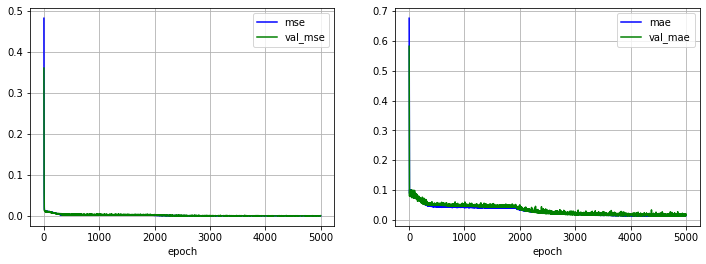

In [13]:
# Visualize error evolution
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12,4))
hist.iloc[0:].plot(x='epoch', y=['mse','val_mse'],ax=ax1,marker="",color=['blue','green'])
plt.grid()
hist.iloc[0:].plot(x='epoch', y=['mae','val_mae'],ax=ax2,marker="",color=['blue','green'])
ax1.grid()
ax2.grid()
plt.show()

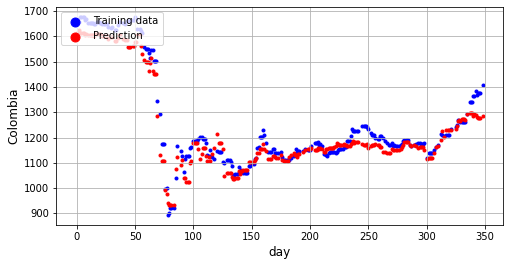

In [14]:
#Test the model vs trainning data and visualize
# Predict and de-scale.
Y_predict_train=model.predict(x_train)*Y_max
Y_train=y_train*Y_max

fig=plt.figure(figsize=(8,4))
plt.ylabel('Colombia', fontsize=12)
plt.xlabel('day', fontsize=12)
plt.scatter(train_time,Y_train, marker=".",color='blue')
plt.scatter(train_time,Y_predict_train,marker=".",color='red')
plt.legend(['Training data','Prediction'],loc="upper left",markerscale=3)
plt.grid()
plt.show()

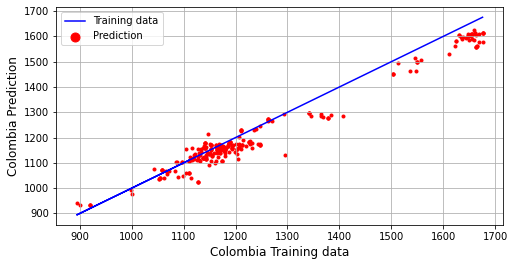

In [15]:
# Visualize Training results
fig=plt.figure(figsize=(8,4))
plt.ylabel('Colombia Prediction', fontsize=12)
plt.xlabel('Colombia Training data', fontsize=12)
plt.plot(Y_train,Y_train,color='blue')
plt.scatter(Y_train,Y_predict_train,marker=".",color='red')
plt.legend(['Training data','Prediction'],loc="upper left",markerscale=3)
plt.grid()
plt.show()

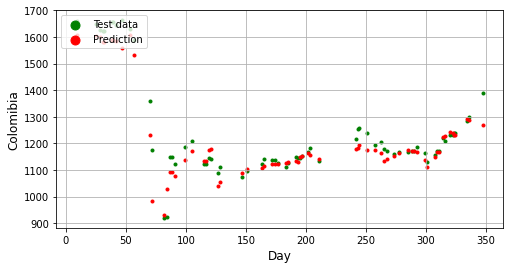

In [16]:
# Test the model vs test data, estimate error, and visualize
# Predict, de-scale, and round
Y_predict_test=model.predict(x_test)*Y_max
Y_predict_test=np.around(Y_predict_test.astype(np.float),2)
Y_test=y_test*Y_max
Y_test=np.around(Y_test.astype(np.float),2)

fig=plt.figure(figsize=(8,4))
plt.ylabel('Colomibia', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.scatter(test_time,Y_test,marker=".",color='green')
plt.scatter(test_time,Y_predict_test,marker=".",color='red')
plt.legend(['Test data','Prediction'],loc="upper left",markerscale=3)
plt.grid()
plt.show()

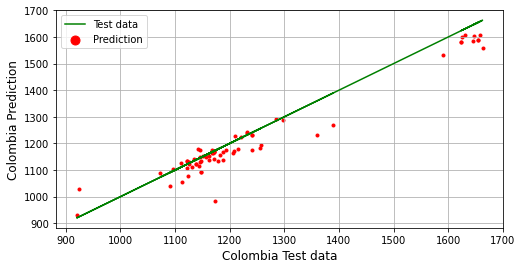

In [17]:
# Visualize test results
fig=plt.figure(figsize=(8,4))
plt.ylabel('Colombia Prediction', fontsize=12)
plt.xlabel('Colombia Test data', fontsize=12)
plt.plot(Y_test,Y_test,color='green')
plt.scatter(Y_test,Y_predict_test,marker=".",color='red')
plt.legend(['Test data','Prediction'],loc="upper left",markerscale=3)
plt.grid()
plt.show()

In [18]:
# Evaluate de model, and print the estimated model errors from testing
loss, val_mse, val_mae  = model.evaluate(x_test,y_test)

print('Test Data Mean Errors in COP:')
mae_COL= np.round(val_mae*Y_max,2)
print('Mean average error:', mae_COL)

mse_COL =np.round(val_mse*Y_max*Y_max,2)
print('Mean squared error:', mse_COL)

rmse_COL =np.round(np.sqrt(val_mse)*Y_max,2)
print('Root mean squared error:', rmse_COL)


70/70 [==============================] - 0s 57us/step
Test Data Mean Errors in COP:
Mean average error: 33.38
Mean squared error: 2303.72
Root mean squared error: 48.0


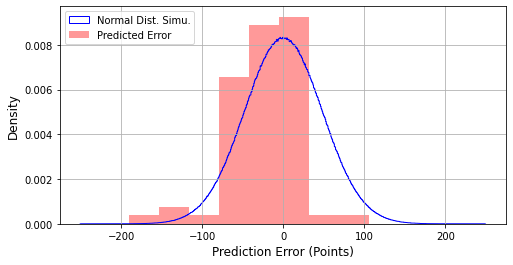

In [19]:
# Visualize the error distribution.
# Reshape labels for comparison

Y_test=Y_test.reshape(test_data_shape[0],1)
Y_predict_test=Y_predict_test.reshape(test_data_shape[0],1)
error=Y_predict_test-Y_test

# Plot Histogram
fig=plt.figure(figsize=(8,4))
plt.ylabel('Density', fontsize=12)
plt.xlabel('Prediction Error (Points)', fontsize=12)

plt.hist(error,bins=8, density=True, alpha=0.4,color='red')

data = np.random.randn(test_data_shape[0]*200000)*rmse_COL
plt.hist(data,bins=700,density=True,histtype='step',linewidth=1, color="blue");
plt.legend(['Normal Dist. Simu.','Predicted Error'],loc="upper left",markerscale=3)
plt.grid()
plt.show()
